In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pandas_profiling
import math
import seaborn as sns
import gc

from datetime import datetime
from pygeocoder import Geocoder

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def currency(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '${:1.1f}M'.format(x*1e-6)
    elif x >= 1000000:
        return '${:1.1f}K'.format(x*1e-3)
    return '${:1.0f}'.format(x*1e-0)

def number(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '{:1.1f}M'.format(x*1e-6)
    elif x >= 100000:
        return '{:1.1f}K'.format(x*1e-3)
    return '{:1.0f}'.format(x*1e-0)

In [4]:
#numRows = 5000  # 5 thousand
#numRows = 50000  # 50 thousand
#numRows = 500000  # 500 thousand
#numRows = 1000000  # 1 million
numRows = 1000000000  # 1 billion
dt = "Jan 2013"
fileMonth = "1"

In [5]:
my_colors =[
            '#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A',
            '#D62728', '#FF9896', '#9467BD', '#C5B0D5', '#8C564B', '#C49C94',
            '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7', '#BCBD22', '#DBDB8D',
            '#17BECF', '#9EDAE5'
        ]

In [6]:
#set the fonts that are on the box so as to stop the warning messages
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Read Data

In [7]:
tripData1 = pd.read_csv('/dltraining/datasets/Trip Data/trip_data_' + fileMonth + '.csv', nrows = numRows)

In [8]:
tripData1.columns = ['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude']


In [9]:
# work out the min and max dates of the pickup time.
minPickup=min(tripData1['pickup_datetime'])
maxPickup=max(tripData1['pickup_datetime'])
print('MinPickup: %s, Max Pickup: %s' % (minPickup, maxPickup))

MinPickup: 2013-01-01 00:00:00, Max Pickup: 2013-01-31 23:59:59


In [10]:
#convert to datetime
tripData1.loc[:, 'pickup_datetime_dt'] = pd.to_datetime(tripData1.loc[:, 'pickup_datetime'])
tripData1.loc[:, 'dropoff_datetime_dt'] = pd.to_datetime(tripData1.loc[:, 'dropoff_datetime'])

In [11]:
tripFare1 = pd.read_csv('/dltraining/datasets/Trip Fare/trip_fare_' + fileMonth + '.csv', nrows = numRows) 

#remove the leading spaces
tripFare1.columns = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax',
       'tip_amount', 'tolls_amount', 'total_amount']

In [12]:
tripFare1.head()

medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
3  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   
4  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   

  vendor_id      pickup_datetime payment_type  fare_amount  surcharge  \
0       CMT  2013-01-01 15:11:48          CSH          6.5        0.0   
1       CMT  2013-01-06 00:18:35          CSH          6.0        0.5   
2       CMT  2013-01-05 18:49:41          CSH          5.5        1.0   
3       CMT  2013-01-07 23:54:15          CSH          5.0        0.5   
4       CMT  2013-01-07 23:25:03          CSH          9.5        0.5   

   mta_tax  tip_amount  tolls_amount  total_amount  
0      0.5         0.0           0.0           7.0  
1      0.5         0.0           0.0           7.0  
2      0.5         0.0           0.0           7.0  
3      0.5         0.0           0.0           6.0  
4      0.5         0.0           0.0          10.5

In [13]:
#convert to datetime
tripFare1.loc[:, 'pickup_datetime_dt'] = pd.to_datetime(tripFare1.loc[:, 'pickup_datetime'])

# Profile the data

if numRows < 100000:
    pandas_profiling.ProfileReport(tripFare1)

if numRows < 100000:
    pandas_profiling.ProfileReport(tripData1)

# Dropping null data

Wanting to only include valid trips within the New York Region

# Boundaries of New York (Lat/Long)
<ul>
  <li>40.706041, -73.927436 - Centre of New York</li>
  <li>41.411137, -74.997657 - Top Left</li>
  <li>40.027137, -74.893068 - Bottom Left</li>
  <li>41.937288, -71.428648 - Top Right</li>
  <li>39.905568, -71.365129 - Bottom Right</li>
</ul>

## Determine range of values should fall between
<ul>
  <li>39.900000 to 42.000000 - Lat Range</li>
  <li>-71.000000 to -75.000000 - Long Range</li>
</ul>


In [14]:
#Drop rows with long / lat data that is either in correct or out of range that we are interested in
print('Old size: %d' % len(tripData1))
tripData1 = tripData1[((tripData1.pickup_longitude<=-71.000000) & (tripData1.pickup_longitude>=-75.000000)) &\
                      ((tripData1.pickup_latitude>=39.900000) & (tripData1.pickup_latitude<=42.000000)) &\
                      ((tripData1.dropoff_longitude<=-71.000000) & (tripData1.dropoff_longitude>=-75.000000)) &\
                      ((tripData1.dropoff_latitude>=39.900000) & (tripData1.dropoff_latitude<=42.000000))]

print('New size: %d' % len(tripData1))

Old size: 14776615
New size: 14488163


## Verify the range of the data

In [15]:
tripData1.dtypes

medallion                      object
hack_license                   object
vendor_id                      object
rate_code                       int64
store_and_fwd_flag             object
pickup_datetime                object
dropoff_datetime               object
passenger_count                 int64
trip_time_in_secs               int64
trip_distance                 float64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
pickup_datetime_dt     datetime64[ns]
dropoff_datetime_dt    datetime64[ns]
dtype: object

In [16]:
# minimum and maximum longitude
min(tripData1.pickup_longitude.min(), tripData1.dropoff_longitude.min()), \
max(tripData1.pickup_longitude.max(), tripData1.dropoff_longitude.max())

(-75.0, -71.01666999999999)

In [17]:
# minimum and maximum latitude
min(tripData1.pickup_latitude.min(), tripData1.dropoff_latitude.min()), \
max(tripData1.pickup_latitude.max(), tripData1.dropoff_latitude.max())

(39.912636, 42.0)

# Joining Data

In [18]:
tripDataFare = pd.merge(tripData1, tripFare1, how='left', left_on = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'pickup_datetime_dt'], right_on = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'pickup_datetime_dt'] )

In [19]:
# Delete the objects used to load the data as we now have a single file so don't need the old ones.
del tripData1, tripFare1

# Create New Fields

## Trip Duration in Minutes

In [20]:
tripDataFare['trip_time_in_min'] = (tripDataFare['trip_time_in_secs']/60)

In [21]:
tripDataFare.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_datetime_dt', 'dropoff_datetime_dt',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'trip_time_in_min'],
      dtype='object')

## Address lookup

In [22]:
# Convert longitude and latitude to a location
#results = Geocoder.reverse_geocode(tripDataFare['pickup_latitude'][0], tripDataFare['pickup_longitude'][0])

# Date Dimensions

In [23]:
def weekDayName(i):
    switcher={
            0:'Monday',
            1:'Tuesday',
            2:'Wednesday',
            3:'Thursday',
            4:'Friday',
            5:'Saturday',
            6:'Sunday'
         }
    return str(switcher.get(i,"Invalid day of week"))

In [24]:
def weekdayWeekend(i):
    switcher={
            0:'Weekday',
            1:'Weekday',
            2:'Weekday',
            3:'Weekday',
            4:'Weekday',
            5:'Weekend',
            6:'Weekend'
         }
    return str(switcher.get(i,"Invalid day of week"))

In [25]:
# create a function to return a value for the time of day it is 
# these values are arbitary and need reviewing
def timeOfDay(i):
    switcher={
            0:'Night',
            1:'Night',
            2:'Night',
            3:'Night',
            4:'Night',
            5:'Night',
            6:'Morning Rush Hour',
            7:'Morning Rush Hour',
            8:'Morning Rush Hour',
            9:'Morning Rush Hour',
            10:'Late morning',
            11:'Late morning',
            12:'Late morning',
            13:'Early afternoon',
            14:'Early afternoon',
            15:'Early afternoon',
            16:'Evening Rush Hour',
            17:'Evening Rush Hour',
            18:'Evening Rush Hour',
            19:'Evening Rush Hour',
            20:'Evening',
            21:'Evening',
            22:'Evening',
            23:'Evening'
         }
    return switcher.get(i,"Invalid Time")

## Pickup

In [26]:
# add date dimensional data for reporting reasons 
tripDataFare["pickup_day"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.day)
tripDataFare["pickup_month"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.month)
tripDataFare["pickup_year"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.year)
tripDataFare["pickup_date"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.date())

tripDataFare["pickup_weekday"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.weekday())  # Monday = 0, Sunday = 6
tripDataFare["pickup_isoweekday"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.isoweekday())  # Monday = 1, Sunday = 7

In [27]:
# add time dimensional data for reporting reasons 
tripDataFare["pickup_hour"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.hour)
tripDataFare["pickup_minute"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.minute)
tripDataFare["pickup_time"] = tripDataFare['pickup_datetime_dt'].map(lambda x: x.time())

In [28]:
# Convert the day number into a day of the week
tripDataFare['pickup_dayName'] = tripDataFare["pickup_weekday"].map(lambda x: weekDayName(x))

In [29]:
# Convert the day number into a day of the week
tripDataFare['pickup_weekdayWeekend'] = tripDataFare["pickup_weekday"].map(lambda x: weekdayWeekend(x))

In [30]:
tripDataFare['pickup_timeOfDay'] = tripDataFare['pickup_hour'].map(lambda x: timeOfDay(x))

## Drop Off

In [31]:
# add date dimensional data for reporting reasons 
tripDataFare["dropoff_day"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.day)
tripDataFare["dropoff_month"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.month)
tripDataFare["dropoff_year"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.year)
tripDataFare["dropoff_date"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.date())

tripDataFare["dropoff_weekday"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.weekday())  # Monday = 0, Sunday = 6
tripDataFare["dropoff_isoweekday"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.isoweekday())  # Monday = 1, Sunday = 7

In [32]:
# add time dimensional data for reporting reasons 
tripDataFare["dropoff_hour"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.hour)
tripDataFare["dropoff_minute"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.minute)
tripDataFare["dropoff_time"] = tripDataFare['dropoff_datetime_dt'].map(lambda x: x.time())

In [33]:
# Convert the day number into a day of the week
tripDataFare['dropoff_dayName'] = tripDataFare["dropoff_weekday"].map(lambda x: weekDayName(x))

In [34]:
# Convert the day number into a day of the week
tripDataFare['dropoff_weekdayWeekend'] = tripDataFare["dropoff_weekday"].map(lambda x: weekdayWeekend(x))

In [35]:
tripDataFare['dropoff_timeOfDay'] = tripDataFare['dropoff_hour'].map(lambda x: timeOfDay(x))

## Trip Distance

In [36]:
def tripLength(i):
    if i <= 0:  # catches 0 and neg numbers as errors
        result = "Error"
    elif i > 0 and i <= 1:
        result = "up to 1 mile"
    elif i > 1 and i <= 5:
        result = "1 to 5 miles"
    elif i > 6 and i <= 10:
        result = "6 to 10 miles"
    elif i > 10 and i <= 20:
        result = "10 to 20 miles"
    else:
        result = "20 + miles"
    return result

In [37]:
def tripDuration(i):
    if i <= 0:  # catches 0 and neg numbers as errors
        result = "Error"
    elif i > 0 and i <= 300: 
        result = "up to 5 minutes"
    elif i > 300 and i <= 600:
        result = "5 to 10 minutes"
    elif i > 600 and i <= 900:
        result = "10 to 15 minutes"
    elif i > 900 and i <= 1200:
        result = "15 to 20 minutes"
    else:
        result = "20 + minutes"
    return result

In [38]:
# Convert the trip distance in a categorical variable
tripDataFare['tripLength'] = tripDataFare["trip_distance"].map(lambda x: tripLength(x))

In [39]:
tripDataFare[['medallion','tripLength']].groupby('tripLength').count()

medallion
tripLength               
1 to 5 miles      9036143
10 to 20 miles     571356
20 + miles         467451
6 to 10 miles      758467
Error               59613
up to 1 mile      3595133

In [40]:
# Convert the trip duration in a categorical variable
tripDataFare['tripDuration'] = tripDataFare["trip_time_in_secs"].map(lambda x: tripDuration(x))

In [41]:
tripDataFare[['medallion','tripDuration']].groupby('tripDuration').count()

medallion
tripDuration               
10 to 15 minutes    3157714
15 to 20 minutes    1648746
20 + minutes        1683989
5 to 10 minutes     5022978
Error                  9891
up to 5 minutes     2964845

# Question 1

How are Revenue, Trips, Passengers tracking over time

In [42]:
title_font = { 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space

In [43]:
print(tripDataFare[['pickup_date', 'passenger_count']].shape)
print(tripDataFare[['pickup_date', 'passenger_count']].head())
print(tripDataFare[['pickup_date', 'passenger_count']].tail())

(14488163, 2)
  pickup_date  passenger_count
0  2013-01-01                4
1  2013-01-06                1
2  2013-01-05                1
3  2013-01-07                2
4  2013-01-07                1
         pickup_date  passenger_count
14488158  2013-01-06                1
14488159  2013-01-08                1
14488160  2013-01-10                1
14488161  2013-01-06                1
14488162  2013-01-05                1


## Number of Trips

In [44]:
# Calc the number of journeys per day
visDataTrips = tripDataFare[['pickup_date','passenger_count']].groupby('pickup_date', as_index=False).count()
# sort the dates
visDataTrips = visDataTrips.sort_values(by=['pickup_date'])
visDataTrips.columns = ['Pickup Date', '# of Trips']
visDataTrips.head()

Pickup Date  # of Trips
0  2013-01-01      404683
1  2013-01-02      385499
2  2013-01-03      432544
3  2013-01-04      468914
4  2013-01-05      464489

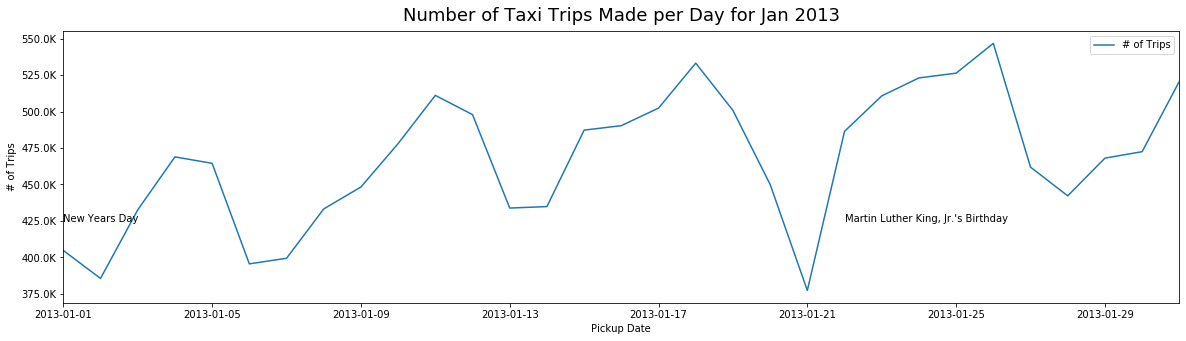

In [45]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of Taxi Trips Made per Day for ' + dt, title_font)

visDataTrips.plot(kind='line', x="Pickup Date", y="# of Trips", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='# of Trips')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

In [46]:
ax.get_ylim()[1] /10

55529.255000000005

## Number of Passengers

In [47]:
# Calc the number of passengers moved per day
visDataPassenger = tripDataFare.groupby(['pickup_date'], as_index=False)['passenger_count'].agg('sum')
# sort the dates
visDataPassenger = visDataPassenger.sort_values(by=['pickup_date'])
visDataPassenger.columns = ['Pickup Date', '# of Passengers']
visDataPassenger.head()

Pickup Date  # of Passengers
0  2013-01-01           742771
1  2013-01-02           660488
2  2013-01-03           733922
3  2013-01-04           801180
4  2013-01-05           827591

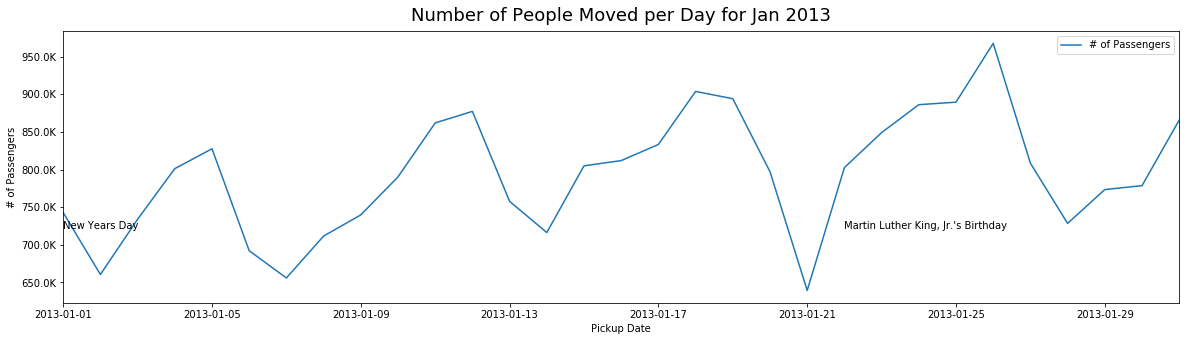

In [48]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of People Moved per Day for ' + dt, title_font)

visDataPassenger.plot(kind='line', x="Pickup Date", y="# of Passengers", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='# of Passengers')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

## Revenue

### Fare Revenue Only

In [49]:
# Calc the number of passengers moved per day
visDataFareRevenue = tripDataFare.groupby(['pickup_date'], as_index=False)['fare_amount'].agg('sum')
# sort the dates
visDataFareRevenue = visDataFareRevenue.sort_values(by=['pickup_date'])
visDataFareRevenue.columns = ['Pickup Date', 'Fare Revenue']
visDataFareRevenue.head()

Pickup Date  Fare Revenue
0  2013-01-01    5174589.49
1  2013-01-02    4605784.16
2  2013-01-03    4978836.57
3  2013-01-04    5273734.56
4  2013-01-05    5235966.73

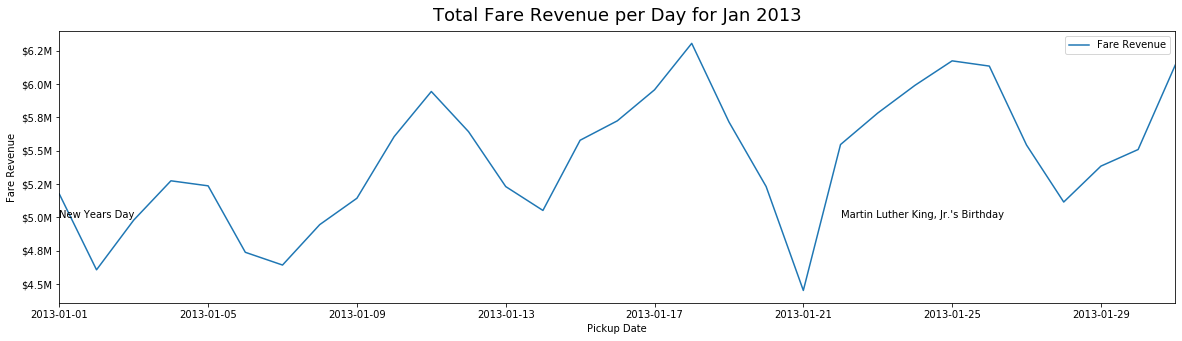

In [50]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Total Fare Revenue per Day for ' + dt, title_font)

visDataFareRevenue.plot(kind='line', x="Pickup Date", y="Fare Revenue", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Fare Revenue')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

### Total Revenue

In [51]:
# Calc the number of passengers moved per day
visDataRevenue = tripDataFare.groupby(['pickup_date'], as_index=False)['total_amount'].agg('sum')
# sort the dates
visDataRevenue = visDataRevenue.sort_values(by=['pickup_date'])
visDataRevenue.columns = ['Pickup Date', 'Total Revenue']
visDataRevenue.head()

Pickup Date  Total Revenue
0  2013-01-01   6.009094e+06
1  2013-01-02   5.473108e+06
2  2013-01-03   5.928965e+06
3  2013-01-04   6.296397e+06
4  2013-01-05   6.140703e+06

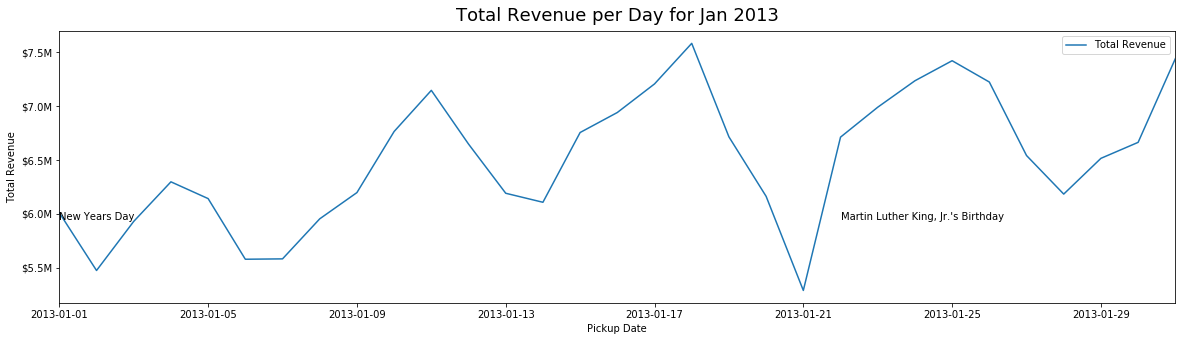

In [52]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Total Revenue per Day for ' + dt, title_font)

visDataRevenue.plot(kind='line', x="Pickup Date", y="Total Revenue", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Total Revenue')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

# Combined

## Fare and Total Fare Revenue

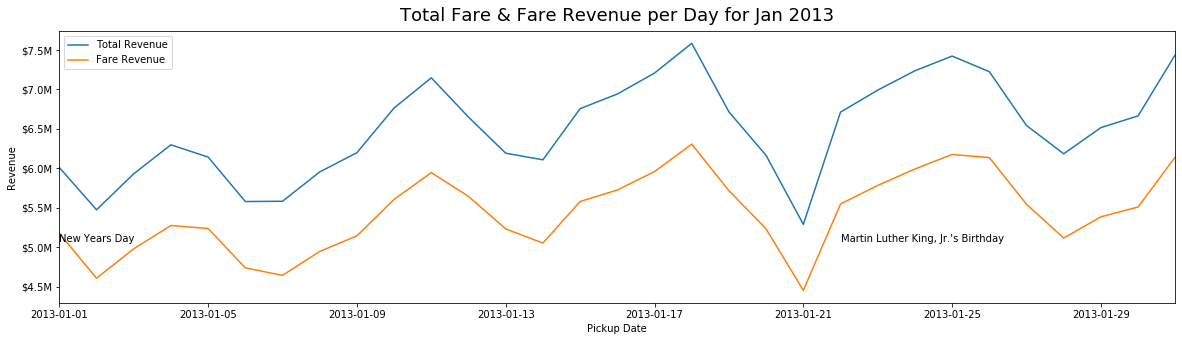

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Total Fare & Fare Revenue per Day for ' + dt, title_font)

visDataRevenue.plot(kind='line', x="Pickup Date", y="Total Revenue", ax=ax)
visDataFareRevenue.plot(kind='line', x="Pickup Date", y="Fare Revenue", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Revenue')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10 , "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10 , "New Years Day")

plt.show()

## Trips and Passengers

## Trips and Passengers

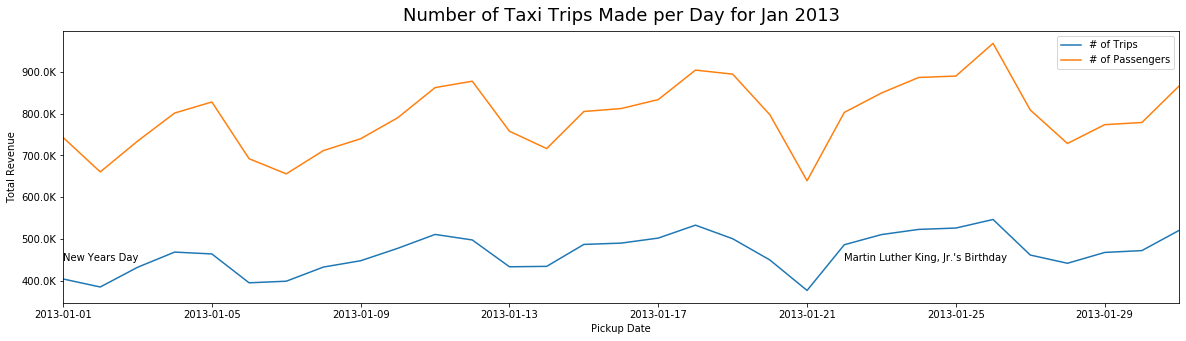

In [54]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of Taxi Trips Made per Day for ' + dt, title_font)

visDataTrips.plot(kind='line', x="Pickup Date", y="# of Trips", ax=ax)
visDataPassenger.plot(kind='line', x="Pickup Date", y="# of Passengers", ax=ax)
ax.set( xlabel='Pickup Date', ylabel='Total Revenue')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

if dt == "Jan 2013":
    ax.text('2013-01-22', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "Martin Luther King, Jr.'s Birthday")
    ax.text('2013-01-01', ax.get_ylim()[0] + ax.get_ylim()[1] /10, "New Years Day")

plt.show()

# Scatter

## # of Trips & # of Passengers

In [55]:
visDataTripsPassengers = pd.merge(visDataTrips, visDataPassenger, how='left', left_on = ['Pickup Date'], right_on = ['Pickup Date'])
visDataTripsPassengers.head()


Pickup Date  # of Trips  # of Passengers
0  2013-01-01      404683           742771
1  2013-01-02      385499           660488
2  2013-01-03      432544           733922
3  2013-01-04      468914           801180
4  2013-01-05      464489           827591

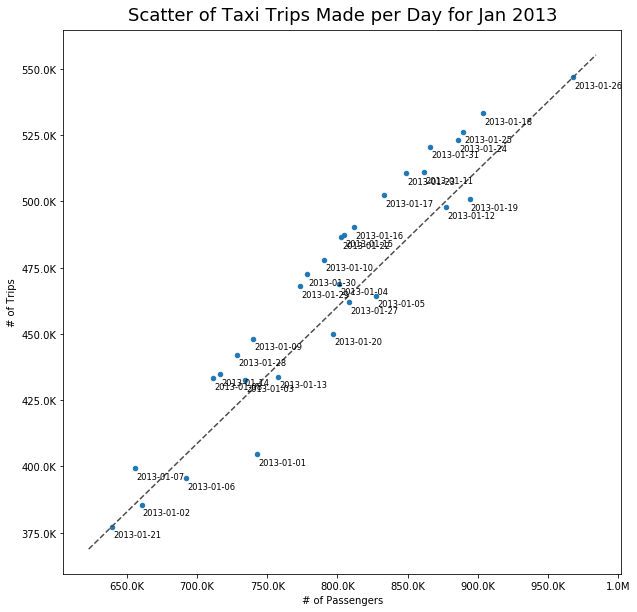

In [56]:
#plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Scatter of Taxi Trips Made per Day for ' + dt, title_font)

visDataTripsPassengers.plot(kind='scatter', x='# of Passengers', y='# of Trips',  s=20, ax=ax)

for line in range(0,visDataTripsPassengers.shape[0]):
    ax.text(visDataTripsPassengers['# of Passengers'][line]+900, visDataTripsPassengers['# of Trips'][line]-4000, \
             visDataTripsPassengers['Pickup Date'][line], horizontalalignment='left', size='small', color='black')

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

## Total Fare Revenue & # of Trips

In [57]:
visDataTripsPassengersRevenue = pd.merge(visDataTripsPassengers, visDataRevenue, how='left', left_on = ['Pickup Date'], right_on = ['Pickup Date'])
visDataTripsPassengersRevenue.head()

Pickup Date  # of Trips  # of Passengers  Total Revenue
0  2013-01-01      404683           742771   6.009094e+06
1  2013-01-02      385499           660488   5.473108e+06
2  2013-01-03      432544           733922   5.928965e+06
3  2013-01-04      468914           801180   6.296397e+06
4  2013-01-05      464489           827591   6.140703e+06

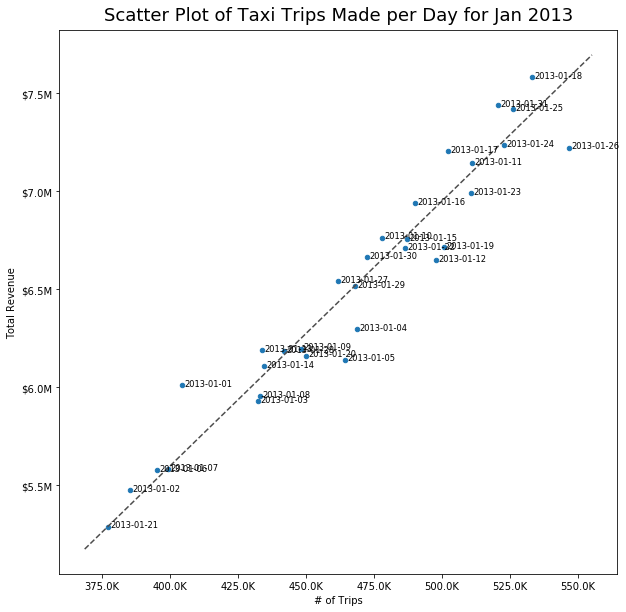

In [58]:
#plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Scatter Plot of Taxi Trips Made per Day for ' + dt, title_font)

visDataTripsPassengersRevenue.plot(kind='scatter', x='# of Trips', y='Total Revenue', s=20 , ax=ax)

for line in range(0,visDataTripsPassengers.shape[0]):
    ax.text(visDataTripsPassengersRevenue['# of Trips'][line]+900, visDataTripsPassengersRevenue['Total Revenue'][line]-4000, \
             visDataTripsPassengersRevenue['Pickup Date'][line], horizontalalignment='left', size='small', color='black')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

## Total Fare Revenue & Fare Revenue

In [59]:
visDataTripsPassengersRevenueFareRevenue = pd.merge(visDataTripsPassengersRevenue, visDataFareRevenue, how='left', left_on = ['Pickup Date'], right_on = ['Pickup Date'])
visDataTripsPassengersRevenueFareRevenue.head()

Pickup Date  # of Trips  # of Passengers  Total Revenue  Fare Revenue
0  2013-01-01      404683           742771   6.009094e+06    5174589.49
1  2013-01-02      385499           660488   5.473108e+06    4605784.16
2  2013-01-03      432544           733922   5.928965e+06    4978836.57
3  2013-01-04      468914           801180   6.296397e+06    5273734.56
4  2013-01-05      464489           827591   6.140703e+06    5235966.73

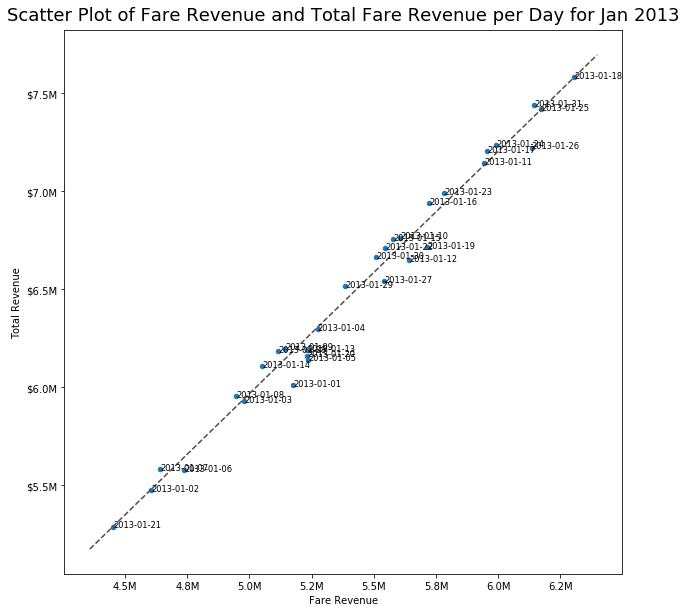

In [60]:
#plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Scatter Plot of Fare Revenue and Total Fare Revenue per Day for ' + dt, title_font)

visDataTripsPassengersRevenueFareRevenue.plot(kind='scatter', x='Fare Revenue', y='Total Revenue', s=20 , ax=ax)

for line in range(0,visDataTripsPassengers.shape[0]):
    ax.text(visDataTripsPassengersRevenueFareRevenue['Fare Revenue'][line]+900, visDataTripsPassengersRevenueFareRevenue['Total Revenue'][line]-4000, \
             visDataTripsPassengersRevenueFareRevenue['Pickup Date'][line], horizontalalignment='left', size='small', color='black')

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

# Question 2


# Visualising the busiest hours

source: https://chih-ling-hsu.github.io/2018/05/14/NYC

In [61]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

## Getting the data into the correct format

In [62]:
def tripVis (tripLengthBoundary = 10):
    visData = tripDataFare[['pickup_hour', 'dropoff_hour']][tripDataFare['trip_distance'] < tripLengthBoundary] 
    visData['count'] = 1
    df_q3_short = visData.groupby(['pickup_hour', 'dropoff_hour'],as_index=False).count()
    df_q3_short.columns = ['PUtime', 'DOtime', 'count']
    #df_q3_short.head()
    visData = tripDataFare[['pickup_hour', 'dropoff_hour']][tripDataFare['trip_distance'] >= tripLengthBoundary] 
    visData['count'] = 1
    df_q3_long = visData.groupby(['pickup_hour', 'dropoff_hour'],as_index=False).count()
    df_q3_long.columns = ['PUtime', 'DOtime', 'count']
    #df_q3_long.head()
    df_q3 = df_q3_short.merge(df_q3_long, how='left', on=["PUtime", "DOtime"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips", \
                                        "PUtime":"pickup time", "DOtime":"dropoff time"})
    #create pickup time dataframe
    df_q3_PU = df_q3.groupby(["pickup time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="pickup time")
    #df_q3_PU.head()
    #create dropoff time dataframe
    df_q3_DO = df_q3.groupby(["dropoff time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="dropoff time")
    #df_q3_DO.head()
    # diff_short_long_trip_on_time()
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

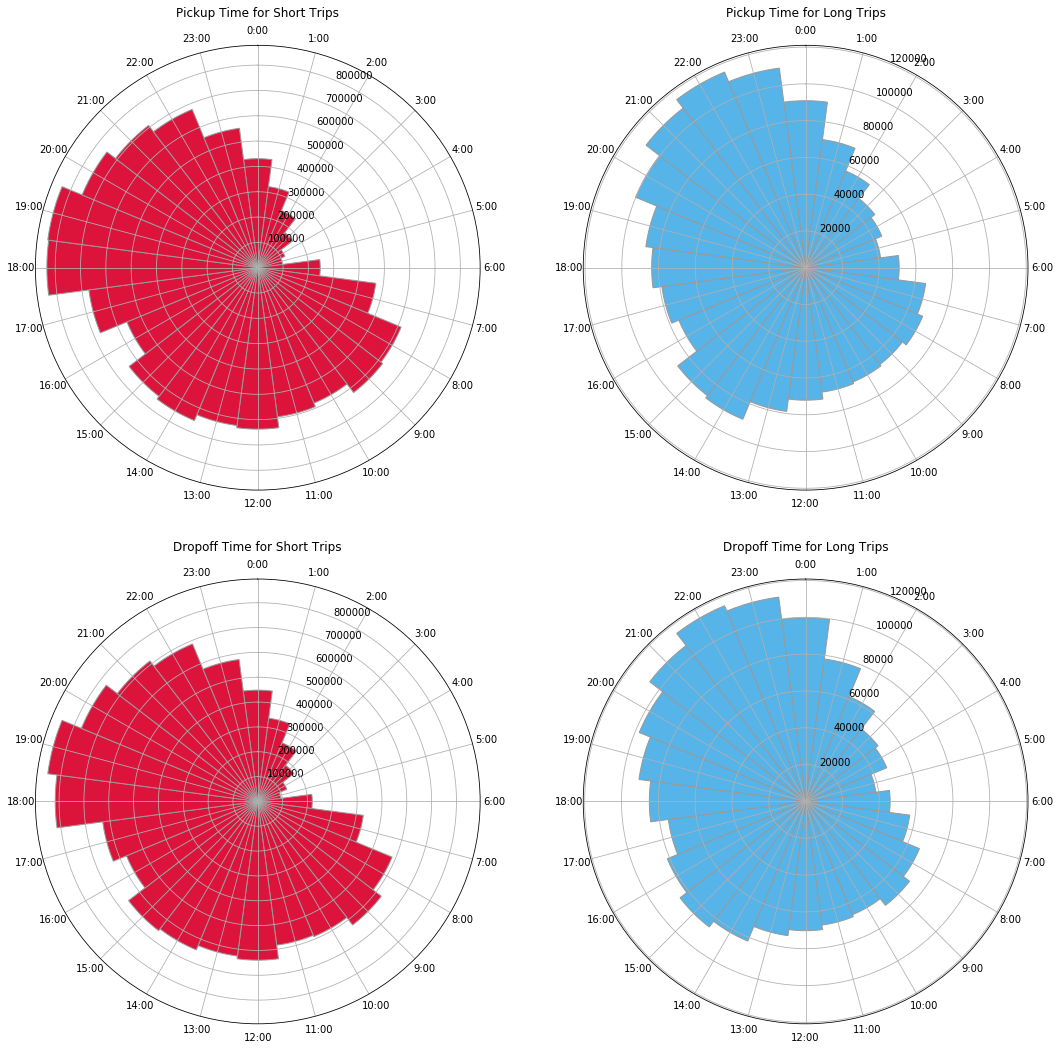

In [63]:
tripVis(5)


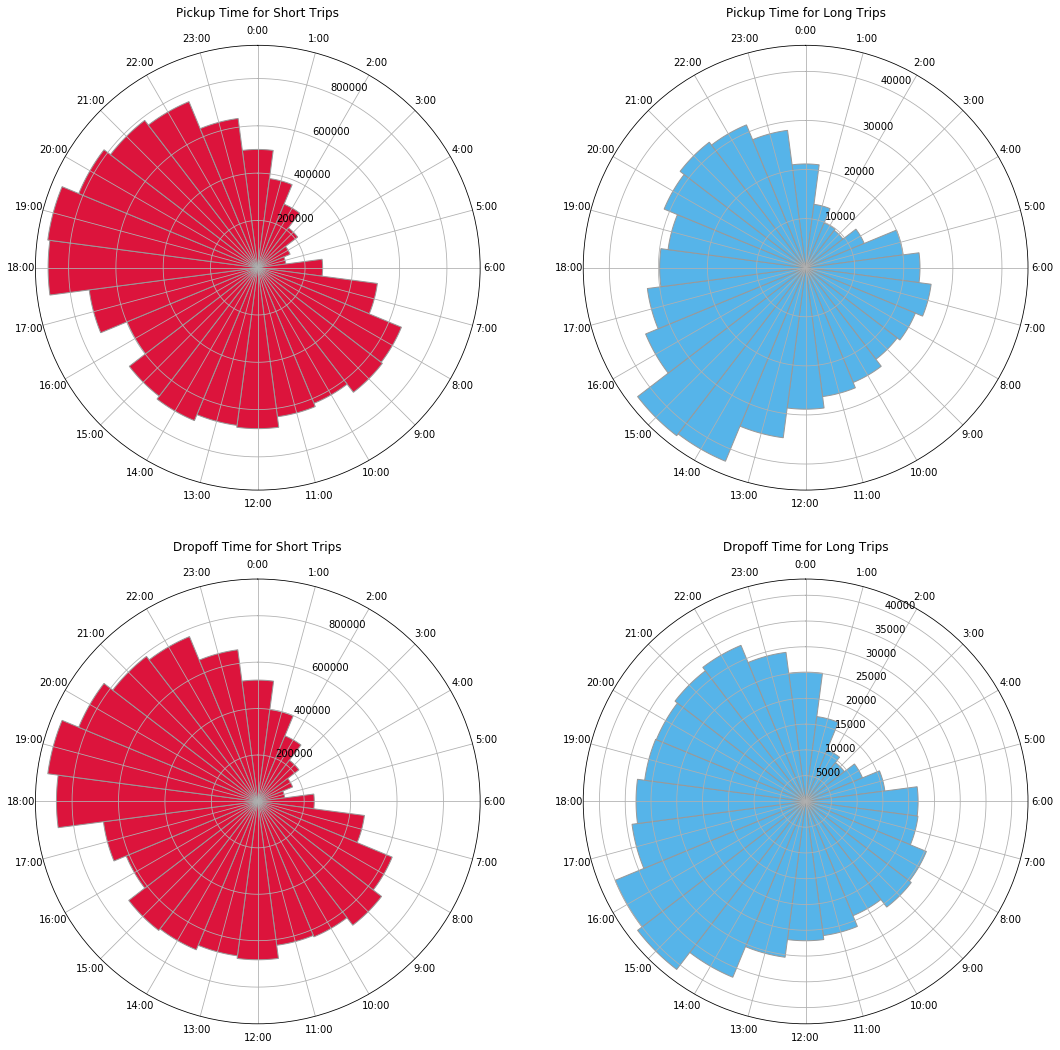

In [64]:
tripVis(10)

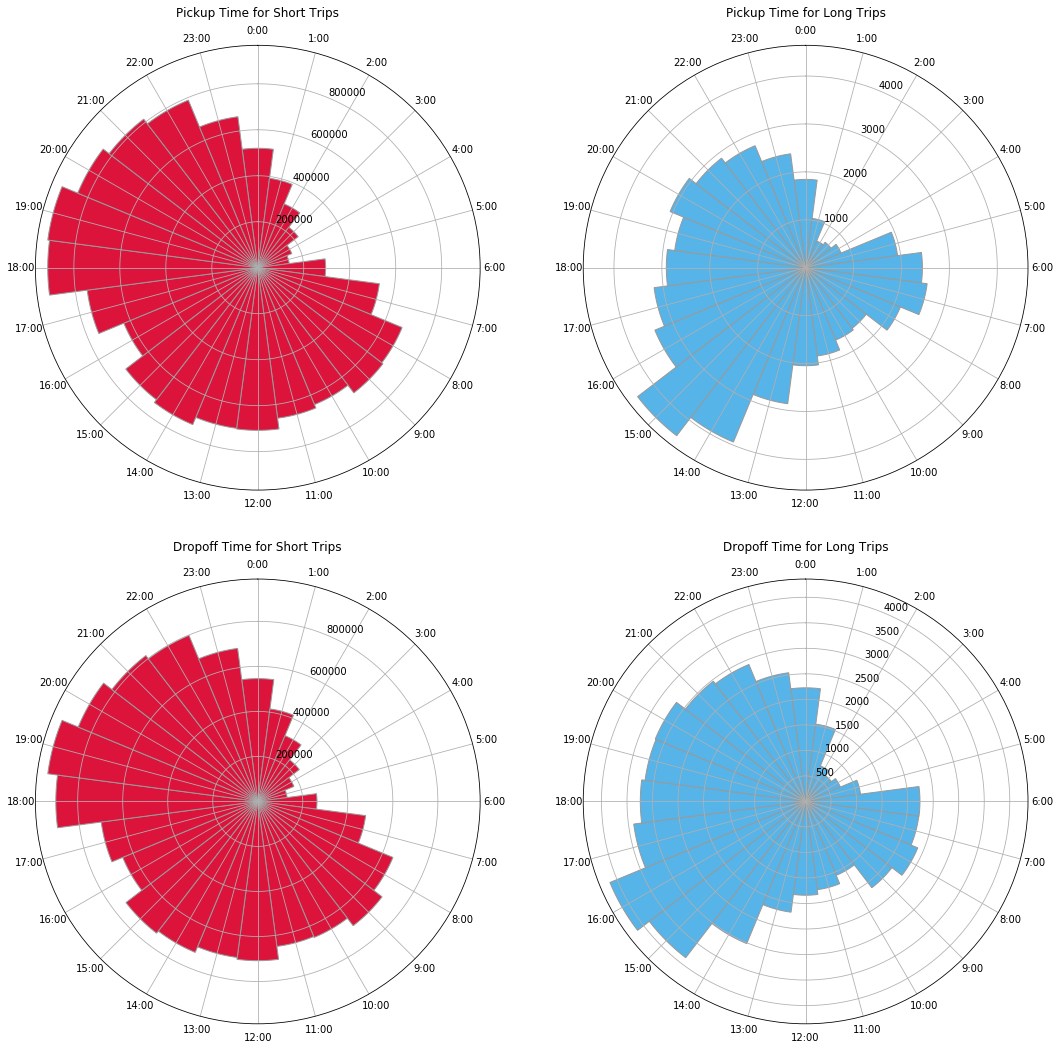

In [65]:
tripVis(20)

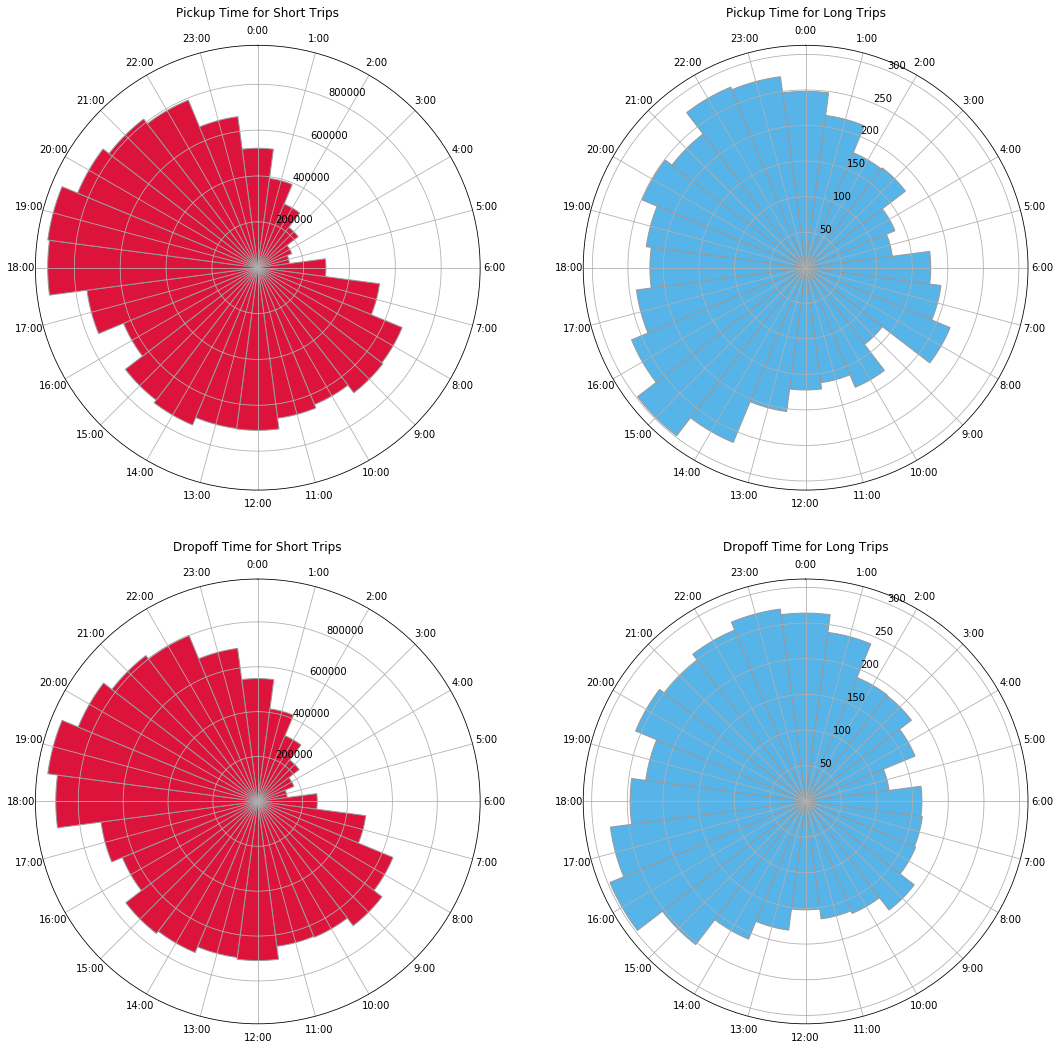

In [66]:
tripVis(30)

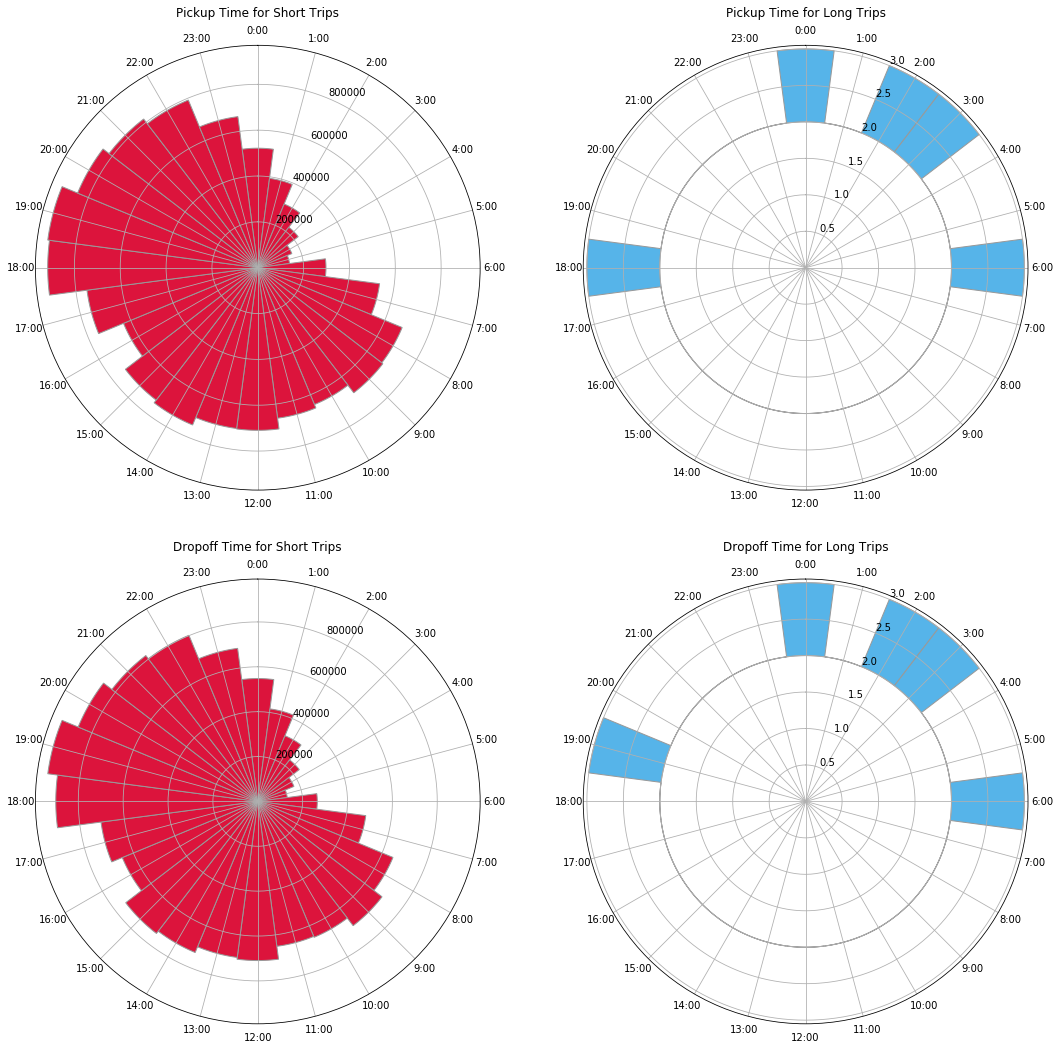

In [67]:
tripVis(100)

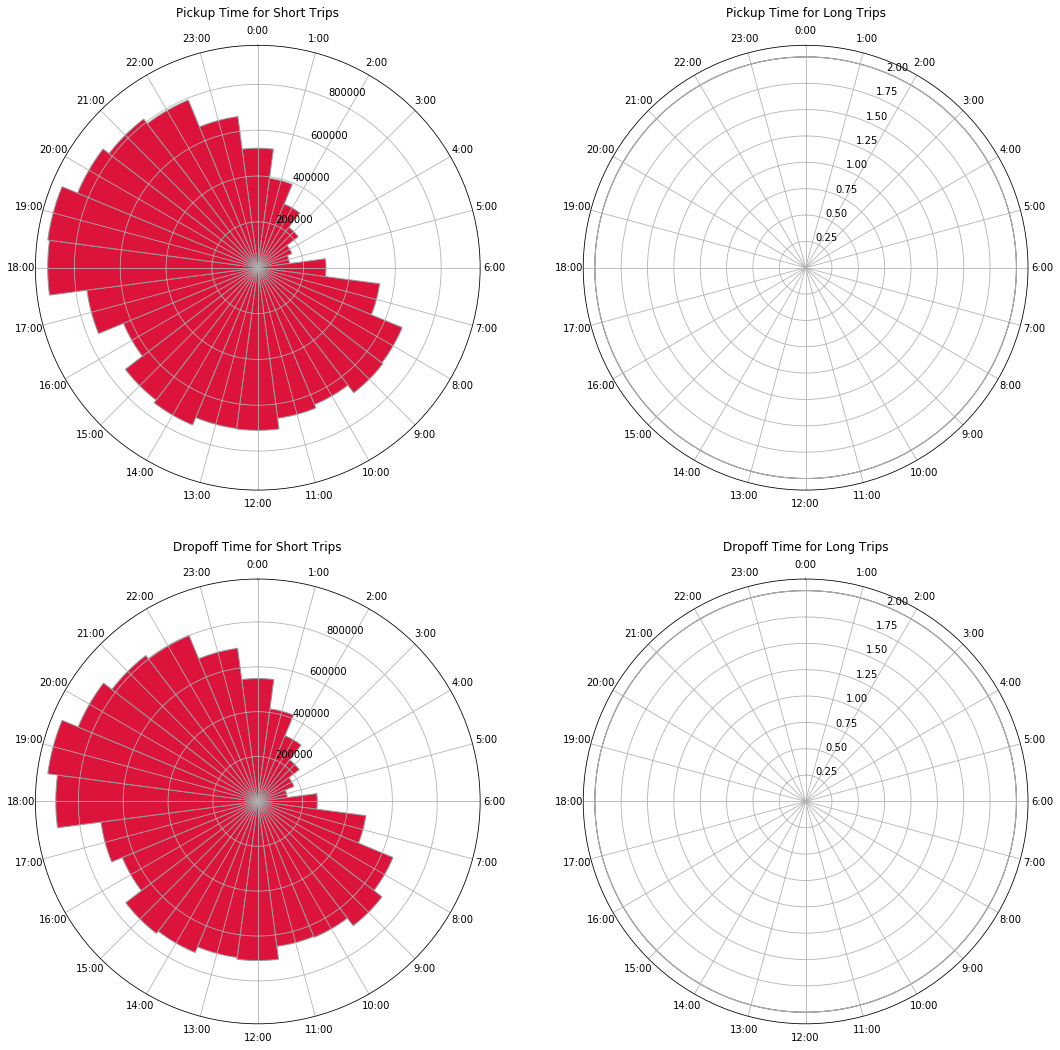

In [68]:
tripVis(200)

In [69]:
del  tripVis

gc.collect()

40622

# Question 3

How are Passengers per trip, payment type, fare and tip amounts distributed?


## Reporting axis ordering section

In [70]:
def retOrderMapping(field):
    if field == 'tripLength':
            return tripLengthOrderMapping
    elif field == 'tripDuration':
        return tripDurationMapping
    elif field == 'pickup_weekdayWeekend':
        return weekdayWeekendMapping
    elif field == 'pickup_dayName':
        return dayNameMapping
    elif field == 'vendor_id':
        return vendor_idOrderMapping
    elif field == 'payment_type':
        return payment_typeOrderMapping  
    elif field == 'Taxi Use':
        return taxiUseOrderMapping  
    elif field == 'pickup_timeOfDay':
        return pickup_timeOfDayOrderMapping

In [71]:
tripLengthOrder = ['up to 1 mile', '1 to 5 miles', '6 to 10 miles', '10 to 20 miles', '20 + miles', 'Error']
# this creates some value key pairs in the correct order
tripLengthOrderMapping = {trip: i for i, trip in enumerate(tripLengthOrder)}
del tripLengthOrder

In [72]:
payment_typeOrder = ['CSH', 'CRD', 'DIS', 'NOC',  'UNK']
# this creates some value key pairs in the correct order
payment_typeOrderMapping = {trip: i for i, trip in enumerate(payment_typeOrder)}
del payment_typeOrder

In [73]:
vendor_idOrder = ['CMT', 'VTS']
# this creates some value key pairs in the correct order
vendor_idOrderMapping = {trip: i for i, trip in enumerate(vendor_idOrder)}
del vendor_idOrder

In [74]:
taxiUseOrder = ['Single Use', 'Low', 'Medium', 'High', 'Extreme', 'Error']
# this creates some value key pairs in the correct order
taxiUseOrderMapping = {trip: i for i, trip in enumerate(taxiUseOrder)}
del taxiUseOrder

In [75]:
pickup_timeOfDayOrder = ['Morning Rush Hour', 'Late morning', 'Early afternoon', 'Evening Rush Hour', 'Evening', 'Night', 'Error' ]
# this creates some value key pairs in the correct order
pickup_timeOfDayOrderMapping = {trip: i for i, trip in enumerate(pickup_timeOfDayOrder)}
del pickup_timeOfDayOrder

In [76]:
weekdayWeekend = ['Weekday', 'Weekend']
# this creates some value key pairs in the correct order
weekdayWeekendMapping = {trip: i for i, trip in enumerate(weekdayWeekend)}
del weekdayWeekend

In [77]:
tripDuration = ['up to 5 minutes', '5 to 10 minutes', '10 to 15 minutes', '15 to 20 minutes', '20 + minutes', 'Error']
# this creates some value key pairs in the correct order
tripDurationMapping = {trip: i for i, trip in enumerate(tripDuration)}
del tripDuration

In [78]:
dayName = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# this creates some value key pairs in the correct order
dayNameMapping = {trip: i for i, trip in enumerate(dayName)}
del dayName

In [79]:
# free memory
gc.collect()

100

In [80]:
# create a df to use for visualising
visDataQ3 = tripDataFare[['pickup_date','passenger_count', 'trip_distance', 'rate_code',
       'store_and_fwd_flag', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'pickup_dayName', 'pickup_weekdayWeekend', 'tripLength',
       'tripDuration']]
visDataQ3.head()

pickup_date  passenger_count  trip_distance  rate_code store_and_fwd_flag  \
0  2013-01-01                4            1.0          1                  N   
1  2013-01-06                1            1.5          1                  N   
2  2013-01-05                1            1.1          1                  N   
3  2013-01-07                2            0.7          1                  N   
4  2013-01-07                1            2.1          1                  N   

  payment_type  fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  \
0          CSH          6.5        0.0      0.5         0.0           0.0   
1          CSH          6.0        0.5      0.5         0.0           0.0   
2          CSH          5.5        1.0      0.5         0.0           0.0   
3          CSH          5.0        0.5      0.5         0.0           0.0   
4          CSH          9.5        0.5      0.5         0.0           0.0   

   total_amount pickup_dayName pickup_weekdayWeekend    tripLength  \
0           7.0        Tuesday               Weekday  up to 1 mile   
1           7.0         Sunday               Weekend  1 to 5 miles   
2           7.0       Saturday               Weekend  1 to 5 miles   
3           6.0         Monday               Weekday  up to 1 mile   
4          10.5         Monday               Weekday  1 to 5 miles   

      tripDuration  
0  5 to 10 minutes  
1  up to 5 minutes  
2  up to 5 minutes  
3  up to 5 minutes  
4  5 to 10 minutes

## Visualisation Section

### Passenger Count by Trip Length

In [81]:
# define which order we are using

orderMapping = tripLengthOrderMapping

In [82]:
byField = 'tripLength'
countField = 'passenger_count'


# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3.head()

tripLength  passenger_count
0    1 to 5 miles         15515160
1  10 to 20 miles          1004816
2      20 + miles           809760
3   6 to 10 miles          1307461
4           Error            78749

In [83]:
# create the sort key
key = visQ3[byField].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripLength  passenger_count
5    up to 1 mile          5886304
0    1 to 5 miles         15515160
3   6 to 10 miles          1307461
1  10 to 20 miles          1004816
2      20 + miles           809760

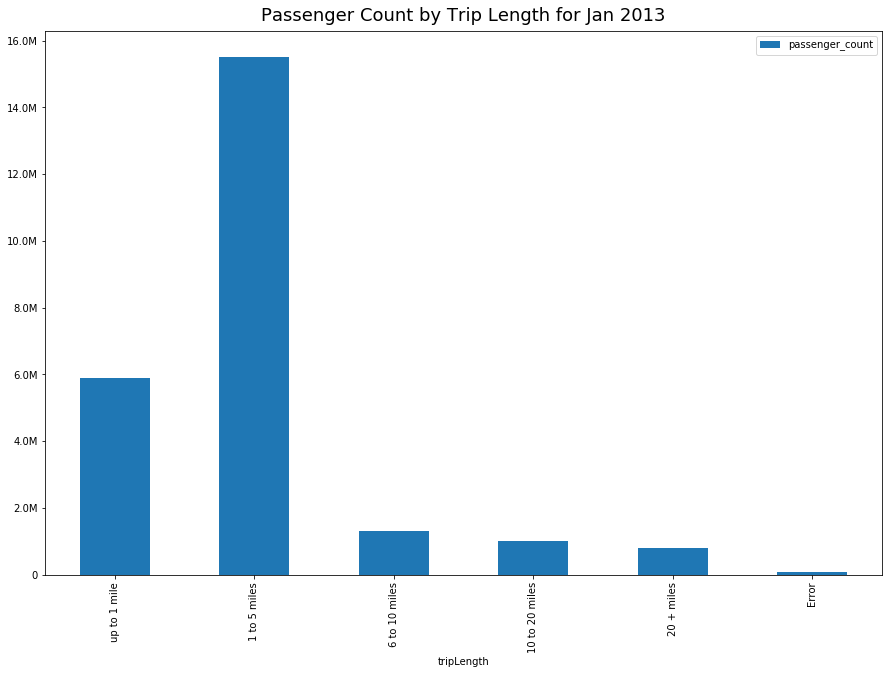

In [84]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Passenger Count by Trip Length for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

### Total Revenue by Trip Length

In [85]:
# define which order we are using
orderMapping = tripLengthOrderMapping

In [86]:
byField = 'tripLength'
countField = 'total_amount'


# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3.head()

tripLength  total_amount
0    1 to 5 miles  1.107319e+08
1  10 to 20 miles  2.882237e+07
2      20 + miles  1.302375e+07
3   6 to 10 miles  2.289279e+07
4           Error  1.643461e+06

In [87]:
# create the sort key
key = visQ3[byField].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripLength  total_amount
5    up to 1 mile  2.445934e+07
0    1 to 5 miles  1.107319e+08
3   6 to 10 miles  2.289279e+07
1  10 to 20 miles  2.882237e+07
2      20 + miles  1.302375e+07

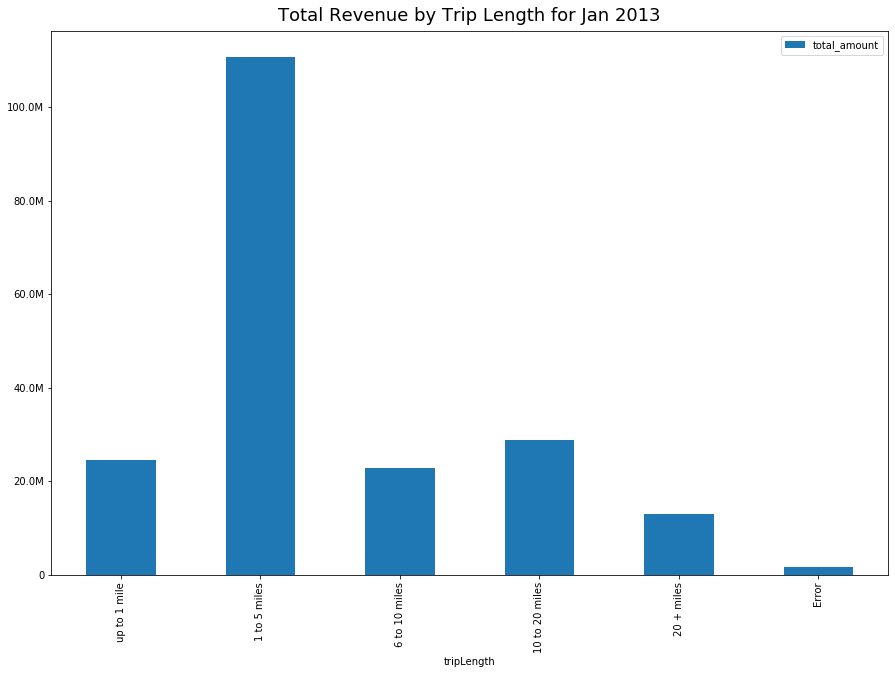

In [88]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Total Revenue by Trip Length for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

### Passenger Count by Trip Duration

In [89]:
# define which order we are using
orderMapping = tripDurationMapping

In [90]:
byField = 'tripDuration'
countField = 'passenger_count'

# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3

tripDuration  passenger_count
0  10 to 15 minutes          5350964
1  15 to 20 minutes          2806299
2      20 + minutes          2890315
3   5 to 10 minutes          8491071
4             Error            18423
5   up to 5 minutes          5045178

In [91]:
visQ3['tripDuration']

0    10 to 15 minutes
1    15 to 20 minutes
2        20 + minutes
3     5 to 10 minutes
4               Error
5     up to 5 minutes
Name: tripDuration, dtype: object

In [92]:
# create the sort key
key = visQ3['tripDuration'].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripDuration  passenger_count
5   up to 5 minutes          5045178
3   5 to 10 minutes          8491071
0  10 to 15 minutes          5350964
1  15 to 20 minutes          2806299
2      20 + minutes          2890315

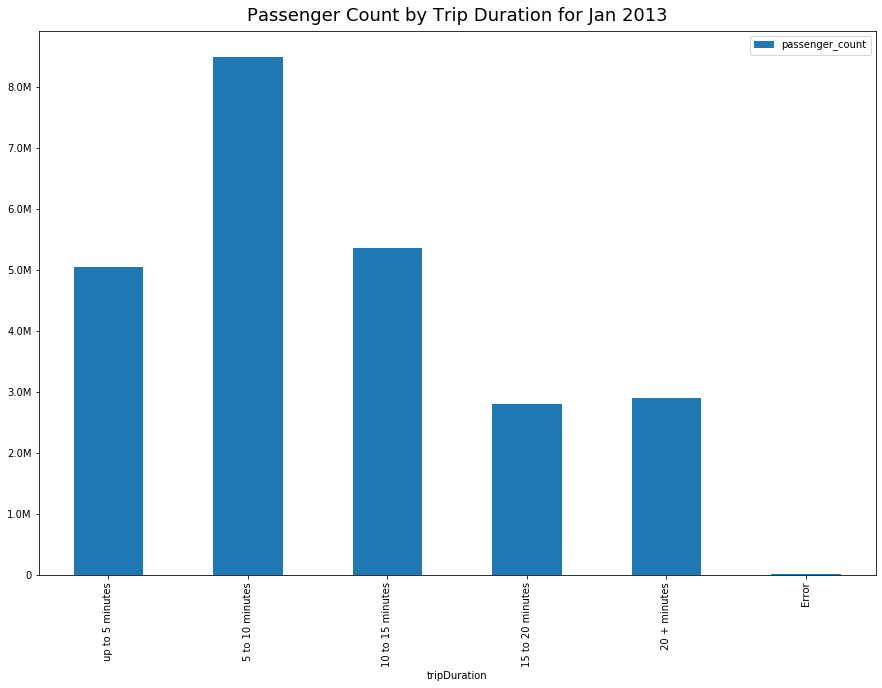

In [93]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Passenger Count by Trip Duration for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

### Total Revenue by Trip Duration

In [94]:
# define which order we are using
orderMapping = tripDurationMapping

In [95]:
byField = 'tripDuration'
countField = 'total_amount'

# Calc the number of journeys per day
visQ3 = visDataQ3[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3

tripDuration  total_amount
0  10 to 15 minutes  4.361705e+07
1  15 to 20 minutes  3.218123e+07
2      20 + minutes  5.879089e+07
3   5 to 10 minutes  4.706624e+07
4             Error  1.961166e+05
5   up to 5 minutes  1.972212e+07

In [96]:
# create the sort key
key = visQ3['tripDuration'].map(orderMapping) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

tripDuration  total_amount
5   up to 5 minutes  1.972212e+07
3   5 to 10 minutes  4.706624e+07
0  10 to 15 minutes  4.361705e+07
1  15 to 20 minutes  3.218123e+07
2      20 + minutes  5.879089e+07

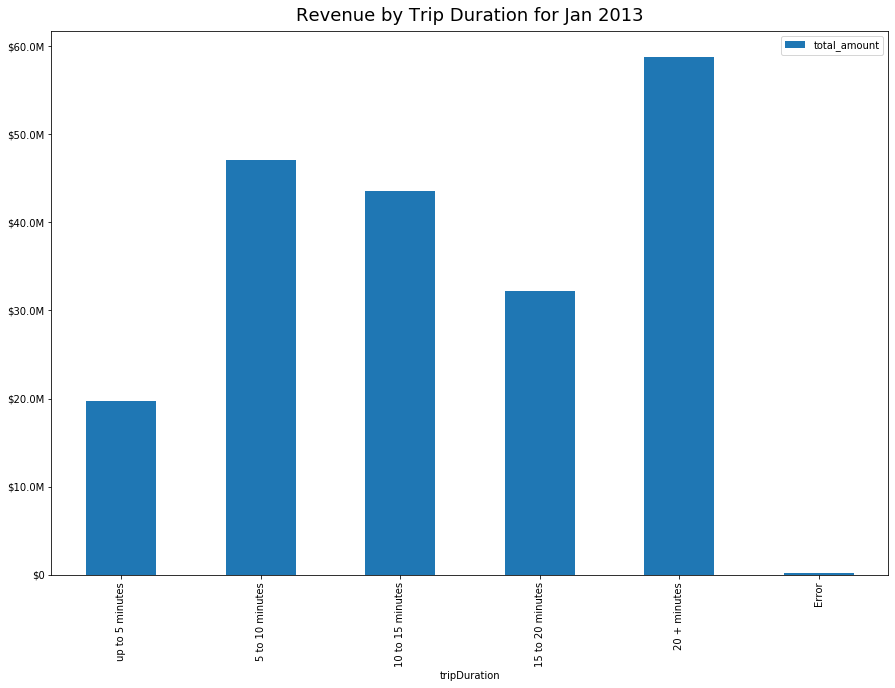

In [97]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Revenue by Trip Duration for ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

plt.show()

## Day of the Week

In [98]:
# define which order we are using
orderMapping = tripDurationMapping

In [99]:
byField = 'pickup_dayName'
countField = 'total_amount'

# Calc the number of journeys per day
visQ3 = tripDataFare[[byField,countField]].groupby(byField, as_index=False)[countField].agg('sum')

visQ3

pickup_dayName  total_amount
0         Friday  2.844491e+07
1         Monday  2.315802e+07
2       Saturday  2.672470e+07
3         Sunday  2.446994e+07
4       Thursday  3.457236e+07
5        Tuesday  3.194194e+07
6      Wednesday  3.226177e+07

In [100]:
# create the sort key
key = visQ3[byField].map(retOrderMapping(byField)) 
# reorganise the dataframe to the correct sort order
visQ3 = visQ3.iloc[key.argsort()]

visQ3.head()

pickup_dayName  total_amount
1         Monday  2.315802e+07
5        Tuesday  3.194194e+07
6      Wednesday  3.226177e+07
4       Thursday  3.457236e+07
0         Friday  2.844491e+07

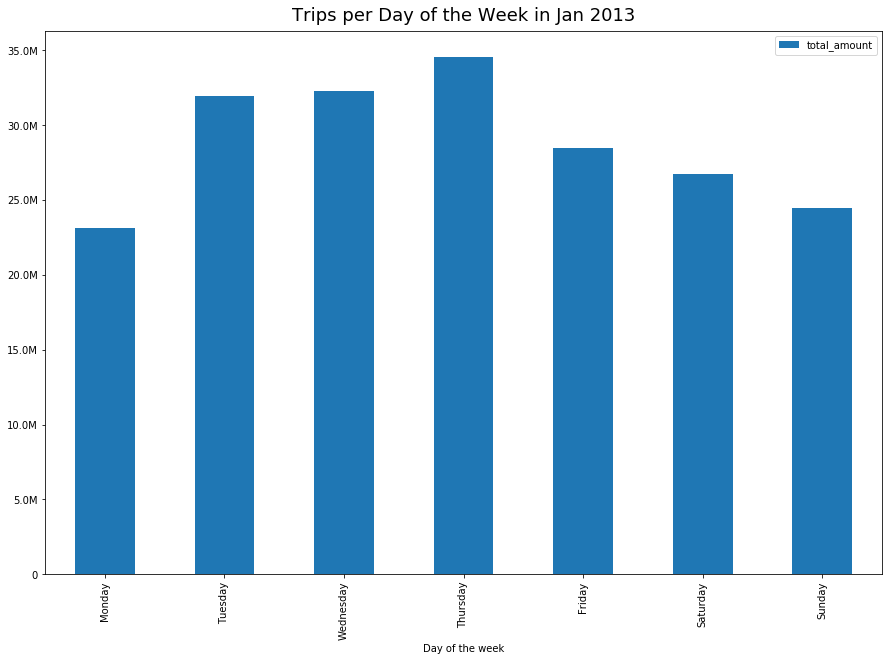

In [101]:

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Trips per Day of the Week in ' + dt, title_font)

visQ3.plot(kind='bar', x=byField, y=countField, ax=ax)
ax.set_xlabel("Day of the week")

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)

plt.show()

In [102]:
#clean up
del visDataQ3, visQ3

gc.collect()

15726

# Drivers

In [103]:
def taxiUse(i):
    # look at the number of taxis they use and categorise on that
    if i <= 0:  # catches 0 and neg numbers as errors
        result = "Error"
    elif i > 0 and i <= 1:
        result = "Single Use"
    elif i > 1 and i <= 5:
        result = "Low"
    elif i > 6 and i <= 10:
        result = "Medium"
    elif i > 10 and i <= 20:
        result = "High"
    else:
        result = "Extreme"
    return result

In [104]:
driverVehicle = tripDataFare[['medallion', 'hack_license', 'fare_amount', 'tip_amount', 'total_amount', 'trip_time_in_secs']]
driverVehicle['count'] = 1

/opt/conda/envs/working/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
#driverVehicle.groupby(['medallion', 'hack_license']).agg('sum')

In [106]:
# filter out some rows for testing code
filter = ['00567B1CBFD51DDFAC73359B09238922', '0002555BBE359440D6CEB34B699D3932', '00B7691D86D96AEBD21DD9E138F90840']
#driverVehicle[driverVehicle['hack_license'].isin(filter)].groupby(['hack_license', 'medallion']).agg('count')

In [107]:
# filter out some rows for testing code
#driverVehicle[['hack_license', 'medallion']][driverVehicle['hack_license'].isin(filter)].groupby(['hack_license'])['medallion'].nunique()

In [108]:
#driverVehicle[driverVehicle['hack_license'].isin(filter)].groupby(['hack_license', 'medallion'], as_index=False).agg('sum')

In [109]:
driverTaxiJourneys = driverVehicle.groupby(['hack_license', 'medallion'], as_index=False).agg('sum')
driverTaxiJourneys.head()

hack_license                         medallion  \
0  0002555BBE359440D6CEB34B699D3932  BE530E79CB7E459DEF5BBDF2F319EDC1   
1  0008B3E338CE8C3377E071A4D80D3694  8FA6FBF2D595A1080BCCE03FC2C213F7   
2  000A4EBF1CEB9C6BD9978D4362493C6E  515D614B20D2BF3BEF939169D925B95C   
3  000B8D660A329BBDBF888500E4BD8B98  5BD01248C41330B7CBE188BCB7808710   
4  000B8D660A329BBDBF888500E4BD8B98  DC1BD2B0B0BE3A6513F54B8138FD9F6A   

   fare_amount  tip_amount  total_amount  trip_time_in_secs  count  
0       6381.5      841.29       7956.49             342782    505  
1       6565.5      728.84       7983.54             363300    543  
2       4586.5      593.95       5680.25             270063    358  
3        198.0       27.69        251.19              12807     22  
4       5929.0      580.59       7057.49             338524    496

In [110]:
driverTaxiJourneys.columns = ['Driver', 'Taxi', 'Fare Amount', 'Tip Amount', 'Total Amount', 'Trip Time (sec)', 'Trip Count',]

In [111]:
# calculate the number of taxis jounreys used by a driver in the data (in this case a month)
# output of value counts is a series so need to convert to frame and then reset the index to bring the driver into a column
driverInfo = driverTaxiJourneys['Driver'].value_counts().to_frame().reset_index()
driverInfo.columns = ['Driver', '# of Taxis']
driverInfo.head()

Driver  # of Taxis
0  00B7691D86D96AEBD21DD9E138F90840         333
1  C1059E614E05082428C20540004D03CE         161
2  AF21D0C97DB2E27E13572CBF59EB343D         155
3  C667D53ACD899A97A85DE0C201BA99BE         144
4  B59C67BF196A4758191E42F76670CEBA         137

In [112]:
# add in the total number of trips the driver has made this month
# this is done inline
driverInfo = pd.merge(driverInfo, \
                      driverTaxiJourneys.groupby(['Driver'], as_index=False).agg(["sum", "mean"]), \
                      how='left', \
                      left_on = ['Driver'], \
                      right_on = ['Driver'] )
driverInfo.head()

/opt/conda/envs/working/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Driver  # of Taxis  (Fare Amount, sum)  \
0  00B7691D86D96AEBD21DD9E138F90840         333             4652.53   
1  C1059E614E05082428C20540004D03CE         161             1072.90   
2  AF21D0C97DB2E27E13572CBF59EB343D         155              665.50   
3  C667D53ACD899A97A85DE0C201BA99BE         144              729.00   
4  B59C67BF196A4758191E42F76670CEBA         137             1095.70   

   (Fare Amount, mean)  (Tip Amount, sum)  (Tip Amount, mean)  \
0            13.971562             239.37            0.718829   
1             6.663975               0.00            0.000000   
2             4.293548               0.00            0.000000   
3             5.062500               0.00            0.000000   
4             7.997810               0.00            0.000000   

   (Total Amount, sum)  (Total Amount, mean)  (Trip Time (sec), sum)  \
0              5503.70             16.527628                  207540   
1              1208.40              7.505590                   31343   
2               789.40              5.092903                   14178   
3               846.15              5.876042                   20501   
4              1238.70              9.041606                   16304   

   (Trip Time (sec), mean)  (Trip Count, sum)  (Trip Count, mean)  
0               623.243243                814            2.444444  
1               194.677019                262            1.627329  
2                91.470968                215            1.387097  
3               142.368056                195            1.354167  
4               119.007299                197            1.437956

In [113]:
driverInfo.columns = ['Driver', '# of Taxis', 'Fare Amount (sum)', 'Fare Amount (mean)', 'Tip Amount (sum)', 'Tip Amount (mean)', 'Total Amount (sum)', 'Total Amount (mean)', 'Trip Time (sec) (sum)', 'Trip Time (sec) (mean)', 'Trip Count (sum)','Trip Count (mean)']

In [114]:
driverInfo['Trips Per Taxi'] = driverInfo['Trip Count (sum)'] / driverInfo['# of Taxis']
driverInfo['Fare Per Trip'] = driverInfo['Fare Amount (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Tip Per Trip'] = driverInfo['Tip Amount (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Amount Per Trip'] = driverInfo['Total Amount (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Journey Time (sec) Per Trip'] = driverInfo['Trip Time (sec) (sum)'] / driverInfo['Trip Count (sum)']
driverInfo['Journey Time (mins) Per Trip'] = (driverInfo['Trip Time (sec) (sum)']/60) / driverInfo['Trip Count (sum)']
driverInfo['Trip Time (mins) (sum)'] = (driverInfo['Trip Time (sec) (sum)']/60)
driverInfo['Trip Time (hrs) (sum)'] = (driverInfo['Trip Time (sec) (sum)']/3600)
driverInfo['Trip Time (mins) (mean)'] = (driverInfo['Trip Time (sec) (mean)']/60)
driverInfo.head()

Driver  # of Taxis  Fare Amount (sum)  \
0  00B7691D86D96AEBD21DD9E138F90840         333            4652.53   
1  C1059E614E05082428C20540004D03CE         161            1072.90   
2  AF21D0C97DB2E27E13572CBF59EB343D         155             665.50   
3  C667D53ACD899A97A85DE0C201BA99BE         144             729.00   
4  B59C67BF196A4758191E42F76670CEBA         137            1095.70   

   Fare Amount (mean)  Tip Amount (sum)  Tip Amount (mean)  \
0           13.971562            239.37           0.718829   
1            6.663975              0.00           0.000000   
2            4.293548              0.00           0.000000   
3            5.062500              0.00           0.000000   
4            7.997810              0.00           0.000000   

   Total Amount (sum)  Total Amount (mean)  Trip Time (sec) (sum)  \
0             5503.70            16.527628                 207540   
1             1208.40             7.505590                  31343   
2              789.40             5.092903                  14178   
3              846.15             5.876042                  20501   
4             1238.70             9.041606                  16304   

   Trip Time (sec) (mean)  Trip Count (sum)  Trip Count (mean)  \
0              623.243243               814           2.444444   
1              194.677019               262           1.627329   
2               91.470968               215           1.387097   
3              142.368056               195           1.354167   
4              119.007299               197           1.437956   

   Trips Per Taxi  Fare Per Trip  Tip Per Trip  Amount Per Trip  \
0        2.444444       5.715639      0.294066         6.761302   
1        1.627329       4.095038      0.000000         4.612214   
2        1.387097       3.095349      0.000000         3.671628   
3        1.354167       3.738462      0.000000         4.339231   
4        1.437956       5.561929      0.000000         6.287817   

   Journey Time (sec) Per Trip  Journey Time (mins) Per Trip  \
0                   254.963145                      4.249386   
1                   119.629771                      1.993830   
2                    65.944186                      1.099070   
3                   105.133333                      1.752222   
4                    82.761421                      1.379357   

   Trip Time (mins) (sum)  Trip Time (hrs) (sum)  Trip Time (mins) (mean)  
0             3459.000000              57.650000                10.387387  
1              522.383333               8.706389                 3.244617  
2              236.300000               3.938333                 1.524516  
3              341.683333               5.694722                 2.372801  
4              271.733333               4.528889                 1.983455

Code to view the counts 
from collections import Counter
hist = Counter(driverInfo['# of Taxis'])


In [115]:
# # look at the number of taxis they use and categorise on that
driverInfo['Taxi Use'] = driverInfo["# of Taxis"].map(lambda x: taxiUse(x))

## Plotting - Driver info

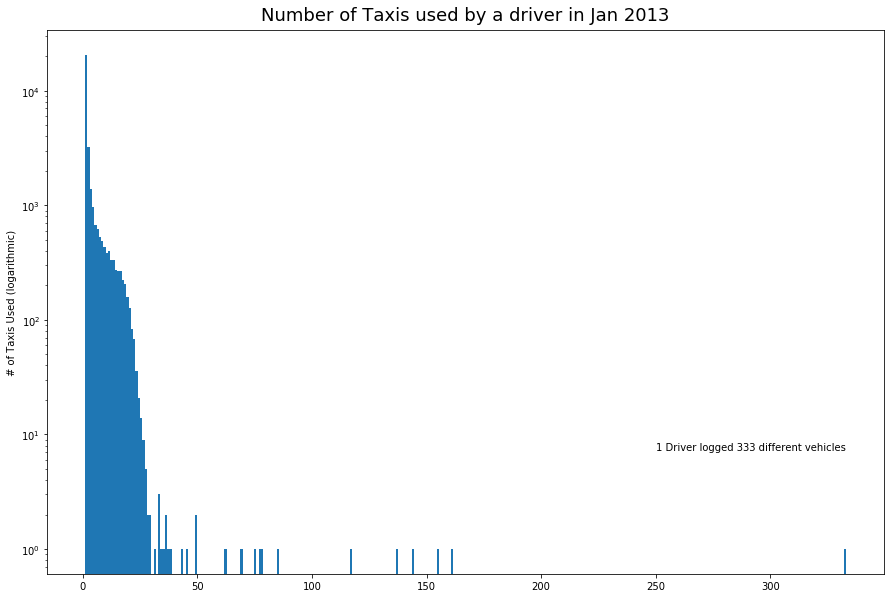

In [116]:
byField = '# of Taxis'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Number of Taxis used by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist',   bins=driverInfo['# of Taxis'].max(), ax=ax)
ax.set_yscale('log')
ax.set_ylabel("# of Taxis Used (logarithmic)")

if dt == "Jan 2013":
    ax.text(250, ax.get_ylim()[0] + ax.get_ylim()[1] /5000, "1 Driver logged 333 different vehicles")
    
plt.show()


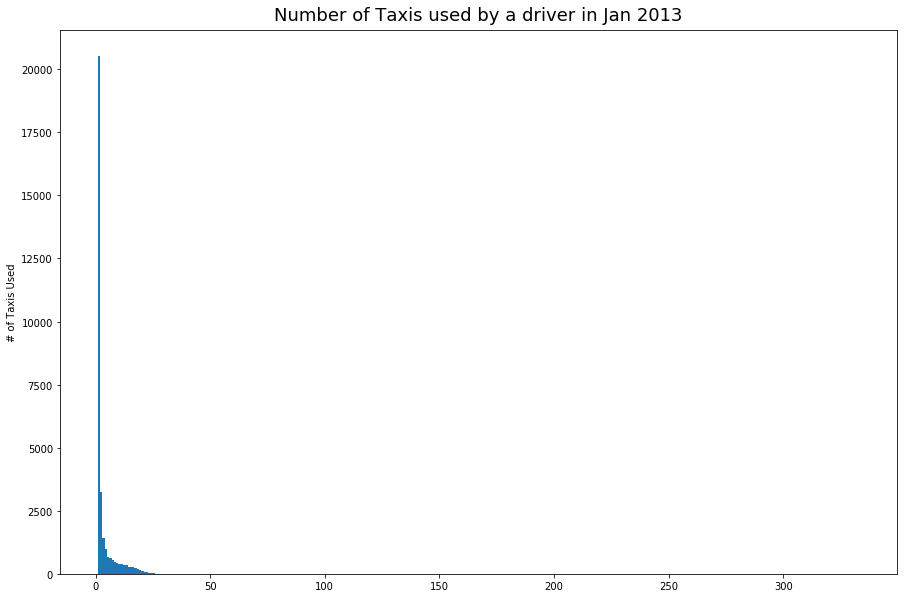

In [117]:
byField = '# of Taxis'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Number of Taxis used by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist',   bins=driverInfo['# of Taxis'].max(), ax=ax)

formatter = FuncFormatter(number)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel("# of Taxis Used")


plt.show()


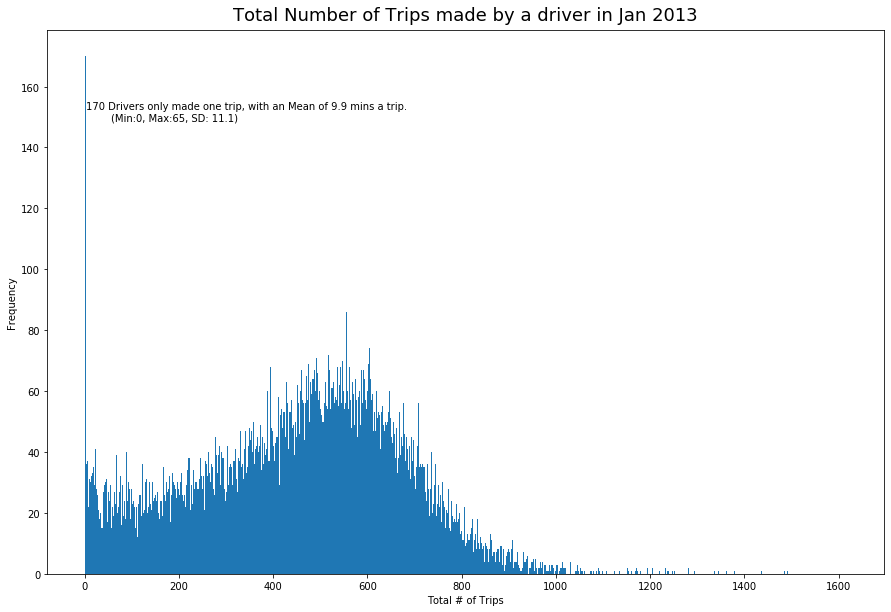

In [118]:
byField = 'Trip Count (sum)'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Total Number of Trips made by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist', bins=driverInfo[byField].max(), ax=ax)
ax.set_xlabel("Total # of Trips")
if dt == "Jan 2013":
    ax.text(3, ax.get_ylim()[0] + ax.get_ylim()[1] /1.2, "%.0f Drivers only made one trip, with an Mean of %.1f mins a trip."  \
    "\n    \
    (Min:%.0f, Max:%.0f, SD: %.1f)" % (driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].count(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mean(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].min(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].max(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].std()))

plt.show()


In [119]:
#Calc for the above chart
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].count())
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mean())
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].min())
print(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mode())

170
9.877156862745098
0.0
0    1.0
dtype: float64


In [120]:
#Counter(driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].astype(int))

In [121]:
print( "%.0f Drivers only made one trip, with an average of %.1f mins a trip."  \
    "(min:%.1f, Max:%.1f, SD: %.1f)" % (driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].count(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].mean(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].min(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].max(), \
                                        driverInfo['Trip Time (mins) (mean)'][driverInfo[byField]==1].std()))

170 Drivers only made one trip, with an average of 9.9 mins a trip.(min:0.0, Max:65.3, SD: 11.1)


### Trips per taxi

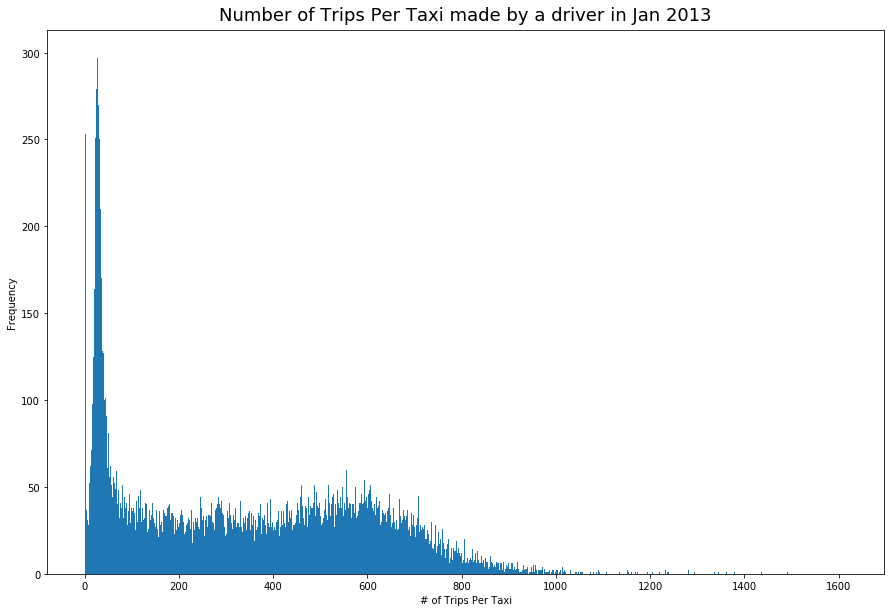

In [122]:
byField = 'Trips Per Taxi'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Number of Trips Per Taxi made by a driver in ' + dt, title_font)

driverInfo[byField].plot(kind='hist', bins=driverInfo[byField].astype(int).max(), ax=ax)
ax.set_xlabel("# of Trips Per Taxi")

plt.show()

In [123]:

driverInfo.head()

Driver  # of Taxis  Fare Amount (sum)  \
0  00B7691D86D96AEBD21DD9E138F90840         333            4652.53   
1  C1059E614E05082428C20540004D03CE         161            1072.90   
2  AF21D0C97DB2E27E13572CBF59EB343D         155             665.50   
3  C667D53ACD899A97A85DE0C201BA99BE         144             729.00   
4  B59C67BF196A4758191E42F76670CEBA         137            1095.70   

   Fare Amount (mean)  Tip Amount (sum)  Tip Amount (mean)  \
0           13.971562            239.37           0.718829   
1            6.663975              0.00           0.000000   
2            4.293548              0.00           0.000000   
3            5.062500              0.00           0.000000   
4            7.997810              0.00           0.000000   

   Total Amount (sum)  Total Amount (mean)  Trip Time (sec) (sum)  \
0             5503.70            16.527628                 207540   
1             1208.40             7.505590                  31343   
2              789.40             5.092903                  14178   
3              846.15             5.876042                  20501   
4             1238.70             9.041606                  16304   

   Trip Time (sec) (mean)  Trip Count (sum)  Trip Count (mean)  \
0              623.243243               814           2.444444   
1              194.677019               262           1.627329   
2               91.470968               215           1.387097   
3              142.368056               195           1.354167   
4              119.007299               197           1.437956   

   Trips Per Taxi  Fare Per Trip  Tip Per Trip  Amount Per Trip  \
0        2.444444       5.715639      0.294066         6.761302   
1        1.627329       4.095038      0.000000         4.612214   
2        1.387097       3.095349      0.000000         3.671628   
3        1.354167       3.738462      0.000000         4.339231   
4        1.437956       5.561929      0.000000         6.287817   

   Journey Time (sec) Per Trip  Journey Time (mins) Per Trip  \
0                   254.963145                      4.249386   
1                   119.629771                      1.993830   
2                    65.944186                      1.099070   
3                   105.133333                      1.752222   
4                    82.761421                      1.379357   

   Trip Time (mins) (sum)  Trip Time (hrs) (sum)  Trip Time (mins) (mean)  \
0             3459.000000              57.650000                10.387387   
1              522.383333               8.706389                 3.244617   
2              236.300000               3.938333                 1.524516   
3              341.683333               5.694722                 2.372801   
4              271.733333               4.528889                 1.983455   

  Taxi Use  
0  Extreme  
1  Extreme  
2  Extreme  
3  Extreme  
4  Extreme

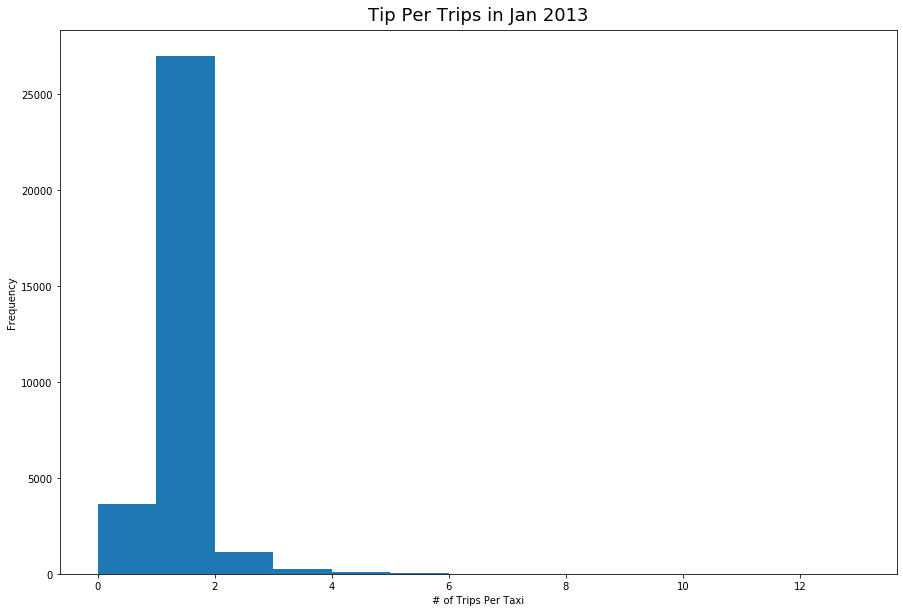

In [124]:
byField = 'Tip Per Trip'
#plot logarithmic
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Tip Per Trips in ' + dt, title_font)

driverInfo[byField].plot(kind='hist',   bins=driverInfo[byField].max().astype(int), ax=ax)
ax.set_xlabel("# of Trips Per Taxi")

plt.show()

## Scatter Plots

To Do: Fix Axis so that they are the same

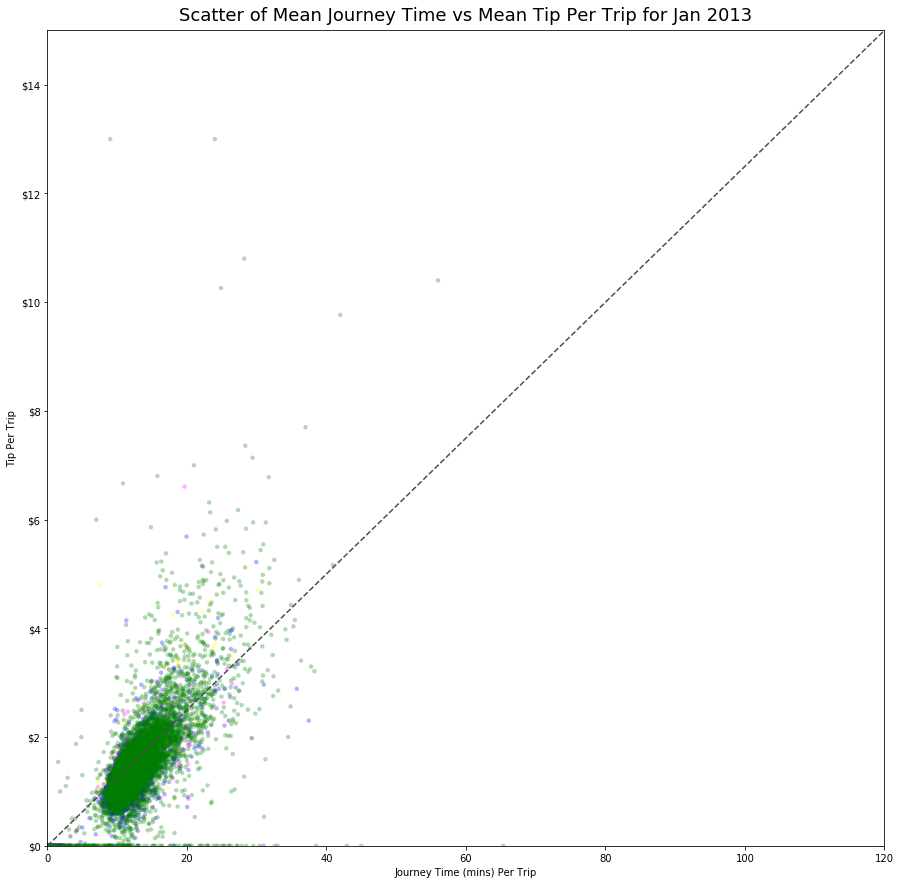

In [125]:
#plot
alpha = 0.3
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Scatter of Mean Journey Time vs Mean Tip Per Trip for ' + dt, title_font)

colors = {"Error":'red', "Single Use":'green', "Low":'blue', "Medium":'yellow', "High":'magenta', "Extreme":'black'}

driverInfo.plot(kind='scatter', y='Tip Per Trip', x='Journey Time (mins) Per Trip',\
                c=driverInfo['Taxi Use'].apply(lambda x: colors[x]), \
                s=20, ax=ax, lw=0, alpha=alpha)


formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim([0,120])
ax.set_ylim([0,15])
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

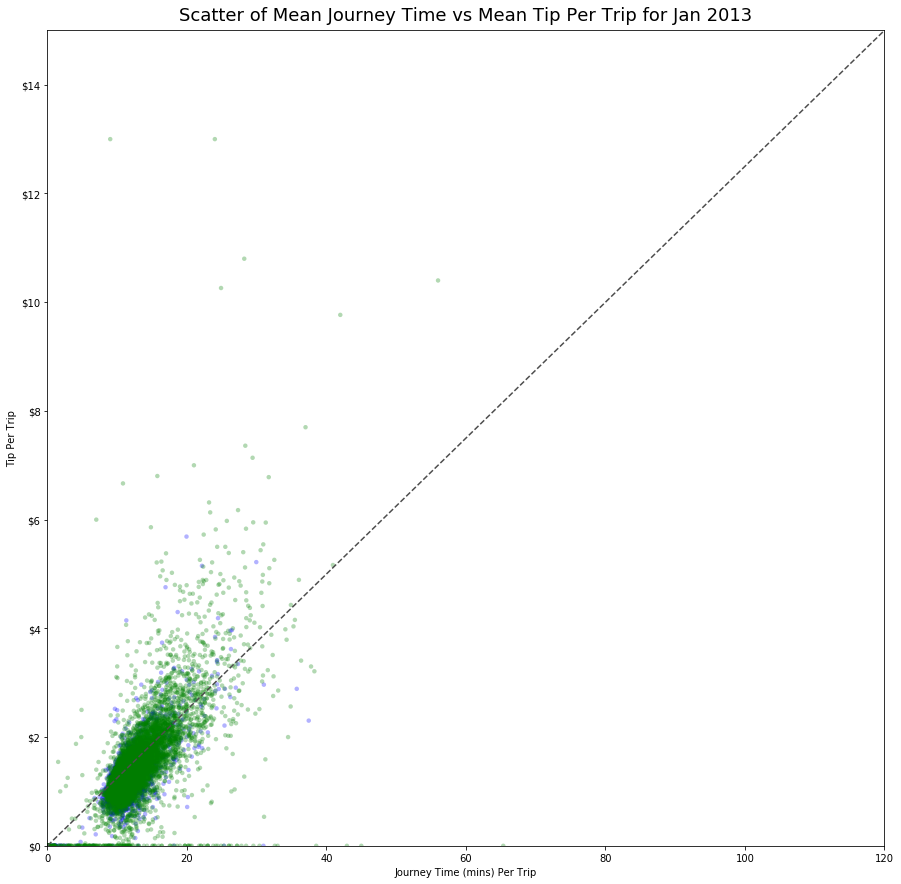

In [126]:
#plot
alpha = 0.3
filter=["Single Use","Low"]

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Scatter of Mean Journey Time vs Mean Tip Per Trip for ' + dt, title_font)

colors = {"Error":'red', "Single Use":'green', "Low":'blue', "Medium":'cyan', "High":'magenta', "Extreme":'black'}

driverInfo[driverInfo['Taxi Use'].isin(filter)].plot(kind='scatter', y='Tip Per Trip', x='Journey Time (mins) Per Trip',\
                c=driverInfo['Taxi Use'][driverInfo['Taxi Use'].isin(filter)].apply(lambda x: colors[x]), \
                s=20, ax=ax, lw=0, alpha=alpha)


formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim([0,120])
ax.set_ylim([0,15])

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

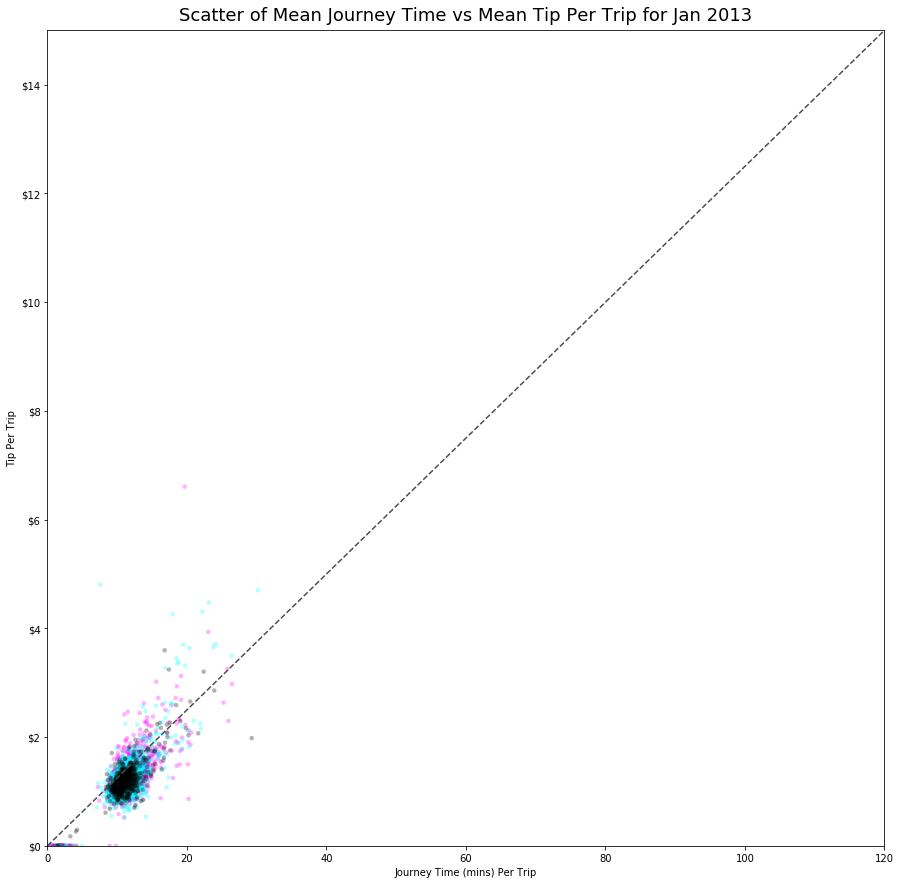

In [127]:
#plot
alpha = 0.3
filter=["Single Use","Low"]

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Scatter of Mean Journey Time vs Mean Tip Per Trip for ' + dt, title_font)

colors = {"Error":'red', "Single Use":'green', "Low":'blue', "Medium":'cyan', "High":'magenta', "Extreme":'black'}

driverInfo[~driverInfo['Taxi Use'].isin(filter)].plot(kind='scatter', y='Tip Per Trip', x='Journey Time (mins) Per Trip',\
                c=driverInfo['Taxi Use'][~driverInfo['Taxi Use'].isin(filter)].apply(lambda x: colors[x]), \
                s=20, ax=ax, lw=0, alpha=alpha)


formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(number)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim([0,120])
ax.set_ylim([0,15])
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

In [128]:
tripDataFare.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_datetime_dt', 'dropoff_datetime_dt',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'trip_time_in_min', 'pickup_day',
       'pickup_month', 'pickup_year', 'pickup_date', 'pickup_weekday',
       'pickup_isoweekday', 'pickup_hour', 'pickup_minute', 'pickup_time',
       'pickup_dayName', 'pickup_weekdayWeekend', 'pickup_timeOfDay',
       'dropoff_day', 'dropoff_month', 'dropoff_year', 'dropoff_date',
       'dropoff_weekday', 'dropoff_isoweekday', 'dropoff_hour',
       'dropoff_minute', 'dropoff_time', 'dropoff_dayName',
       'dropoff_weekdayWeekend', 'dropoff_timeOfDay', 'tripLength',
       'tripDuration'],
      dtype='ob

In [129]:
tripDataFare = pd.merge(tripDataFare, driverInfo[['Driver', 'Taxi Use']], \
                        how='left', left_on = ['hack_license'], right_on = ['Driver'])
# dont need the extra column as it is the same
tripDataFare.drop('Driver', axis=1)
tripDataFare.head()

medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
3  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   
4  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-01-01 15:11:48   
1       CMT          1                  N  2013-01-06 00:18:35   
2       CMT          1                  N  2013-01-05 18:49:41   
3       CMT          1                  N  2013-01-07 23:54:15   
4       CMT          1                  N  2013-01-07 23:25:03   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-01 15:18:10                4                382            1.0   
1  2013-01-06 00:22:54                1                259            1.5   
2  2013-01-05 18:54:23                1                282            1.1   
3  2013-01-07 23:58:20                2                244            0.7   
4  2013-01-07 23:34:24                1                560            2.1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.978165        40.757977         -73.989838         40.751171   
1        -74.006683        40.731781         -73.994499         40.750660   
2        -74.004707        40.737770         -74.009834         40.726002   
3        -73.974602        40.759945         -73.984734         40.759388   
4        -73.976250        40.748528         -74.002586         40.747868   

   pickup_datetime_dt dropoff_datetime_dt payment_type  fare_amount  \
0 2013-01-01 15:11:48 2013-01-01 15:18:10          CSH          6.5   
1 2013-01-06 00:18:35 2013-01-06 00:22:54          CSH          6.0   
2 2013-01-05 18:49:41 2013-01-05 18:54:23          CSH          5.5   
3 2013-01-07 23:54:15 2013-01-07 23:58:20          CSH          5.0   
4 2013-01-07 23:25:03 2013-01-07 23:34:24          CSH          9.5   

   surcharge  mta_tax  tip_amount  tolls_amount  total_amount  \
0        0.0      0.5         0.0           0.0           7.0   
1        0.5      0.5         0.0           0.0           7.0   
2        1.0      0.5         0.0           0.0           7.0   
3        0.5      0.5         0.0           0.0           6.0   
4        0.5      0.5         0.0           0.0          10.5   

   trip_time_in_min  pickup_day  pickup_month  pickup_year pickup_date  \
0          6.366667           1             1         2013  2013-01-01   
1          4.316667           6             1         2013  2013-01-06   
2          4.700000           5             1         2013  2013-01-05   
3          4.066667           7             1         2013  2013-01-07   
4          9.333333           7             1         2013  2013-01-07   

   pickup_weekday  pickup_isoweekday  pickup_hour  pickup_minute pickup_time  \
0               1                  2           15             11    15:11:48   
1               6                  7            0             18    00:18:35   
2               5                  6           18             49    18:49:41   
3               0                  1           23             54    23:54:15   
4               0                  1           23             25    23:25:03   

  pickup_dayName pickup_weekdayWeekend   pickup_timeOfDay  dropoff_day  \
0        Tuesday               Weekday    Early afternoon            1   
1         Sunday               Weekend              Night            6   
2       Saturday               Weekend  Evening Rush Hour            5   
3         Monday               Weekday            Evening            7   
4         Monday               Weekday            Evening            7   

   dropoff_month  dropoff_year dropoff_date  dropoff_weekday  \
0          

In [130]:
del driverInfo, driverTaxiJourneys, driverVehicle
gc.collect()

144024

In [131]:
del visDataFareRevenue, visDataPassenger,  visDataRevenue, visDataTrips, visDataTripsPassengers, \
visDataTripsPassengersRevenue, visDataTripsPassengersRevenueFareRevenue

gc.collect()

266

In [132]:
gc.collect()

20

## Boxplots


In [133]:
def comparisonBoxplots(xaxis, yaxis, palette, title="No Title Supplied", showmeans=True, showfliers=True):
    fig = plt.figure(1, figsize=(10,5))
    ax = sns.boxplot(x=xaxis, y=yaxis, palette=palette, showmeans=showmeans, showfliers=showfliers)
    # set the title of the chart
    plt.title(title)
    # set the labels - x  is blank because we don't need it to say "Summary"
    ax.set(xlabel='', ylabel='')
    # set the labels on the individual x-axis columns
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=25)
    plt.show()
    print('-' * 100)
    return



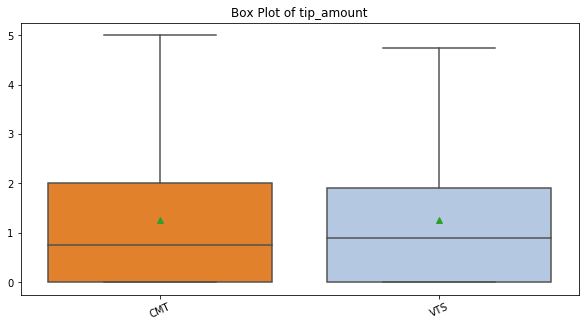

----------------------------------------------------------------------------------------------------


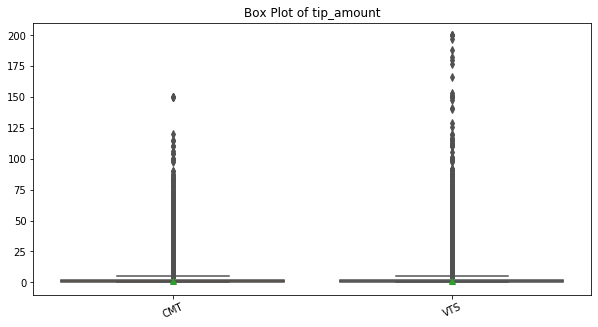

----------------------------------------------------------------------------------------------------


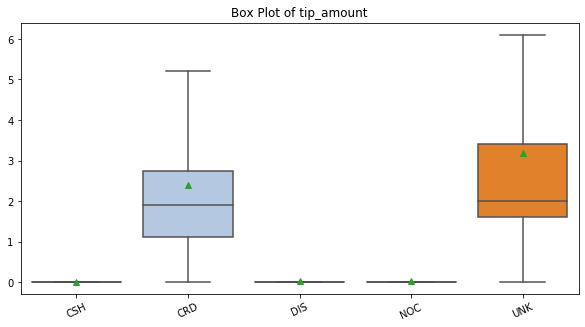

----------------------------------------------------------------------------------------------------


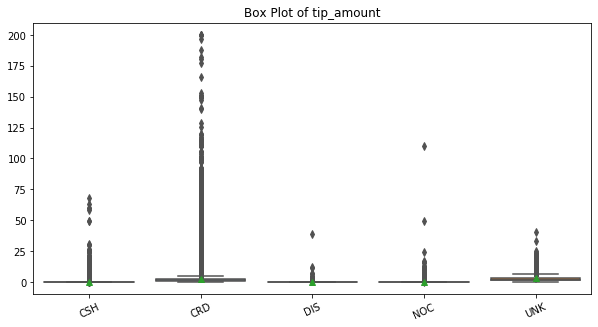

----------------------------------------------------------------------------------------------------


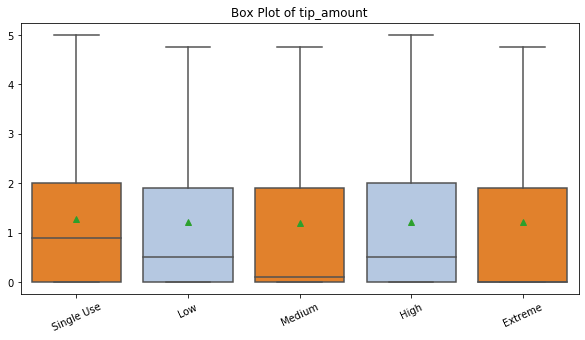

----------------------------------------------------------------------------------------------------


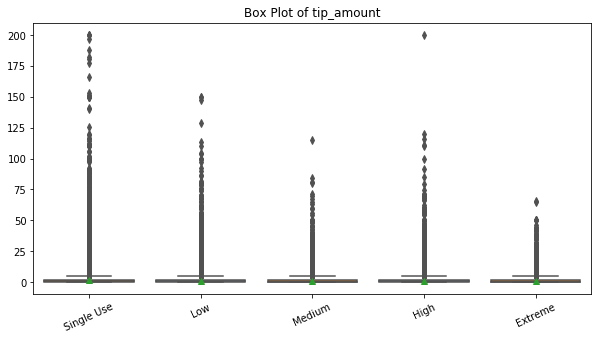

----------------------------------------------------------------------------------------------------


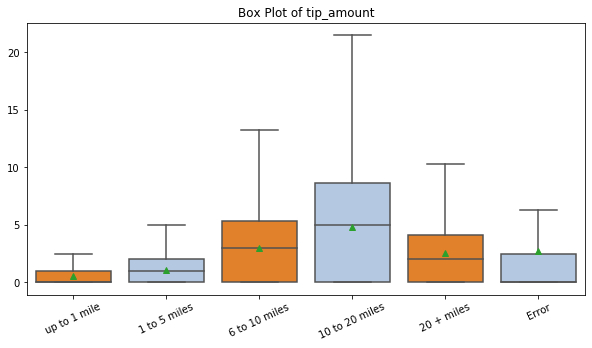

----------------------------------------------------------------------------------------------------


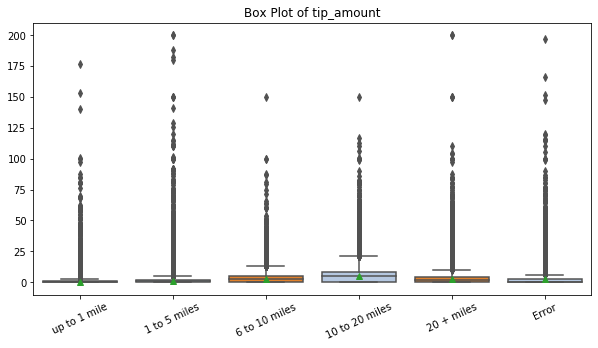

----------------------------------------------------------------------------------------------------


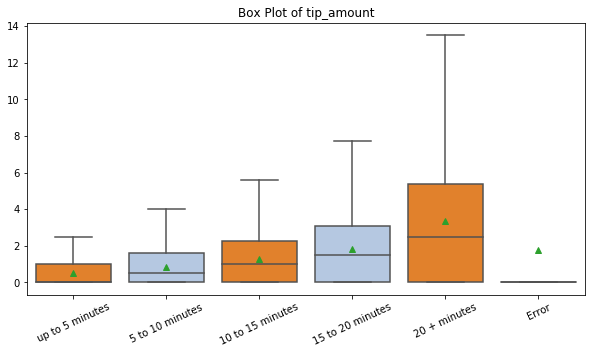

----------------------------------------------------------------------------------------------------


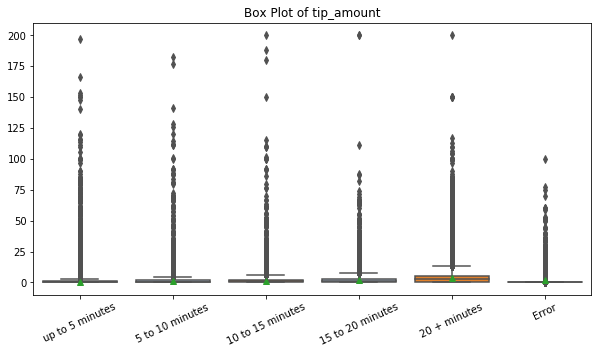

----------------------------------------------------------------------------------------------------


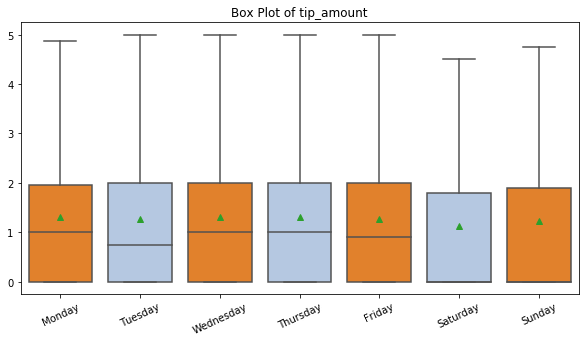

----------------------------------------------------------------------------------------------------


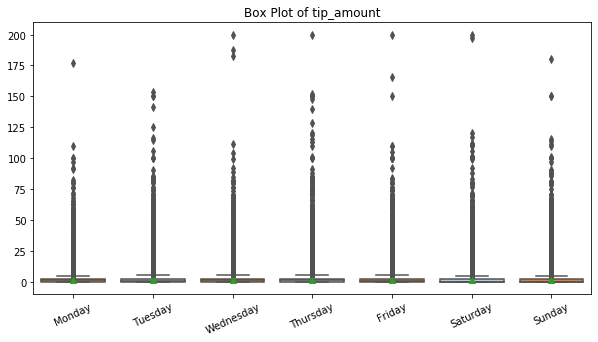

----------------------------------------------------------------------------------------------------


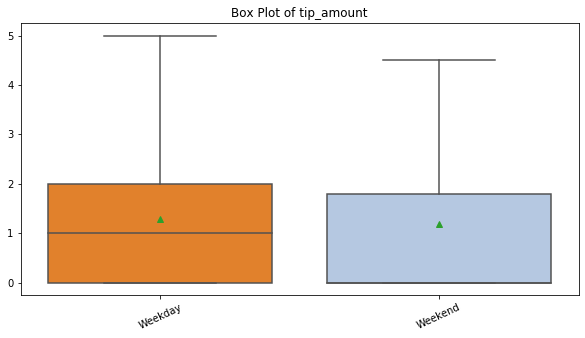

----------------------------------------------------------------------------------------------------


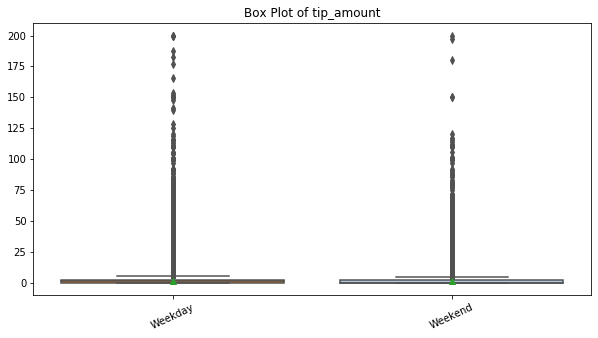

----------------------------------------------------------------------------------------------------


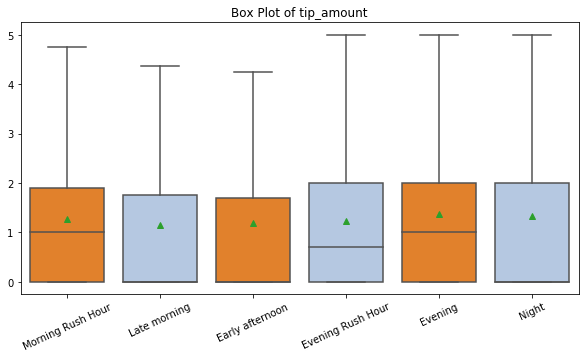

----------------------------------------------------------------------------------------------------


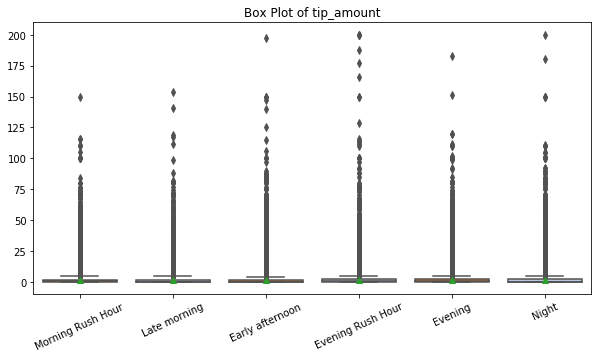

----------------------------------------------------------------------------------------------------


In [134]:
plotValue = ['tip_amount']
byValue = ['vendor_id', 'payment_type', 'Taxi Use', 'tripLength', 'tripDuration',  'pickup_dayName', \
           'pickup_weekdayWeekend', 'pickup_timeOfDay']

for pv in plotValue:
    for bv in byValue:
        #reorder the df to print nicely
        key = tripDataFare[bv].map(retOrderMapping(bv))
        tripDataFare = tripDataFare.iloc[key.argsort()]
        #print the first chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=False)
        # print the second chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=True)

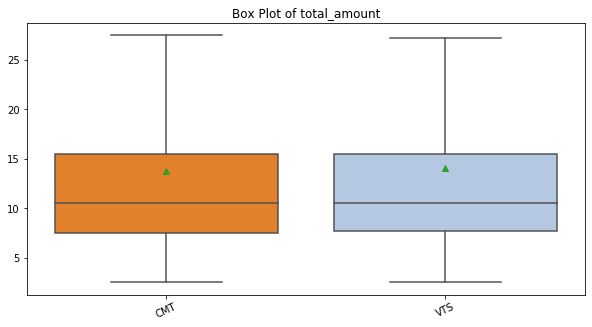

----------------------------------------------------------------------------------------------------


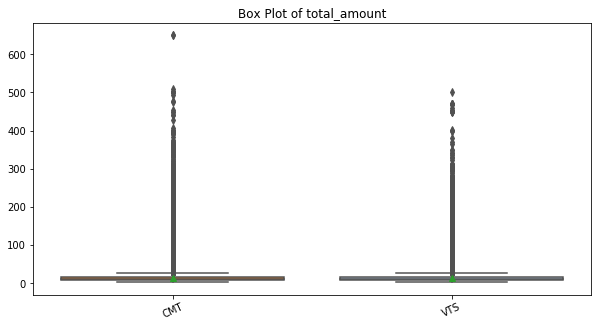

----------------------------------------------------------------------------------------------------


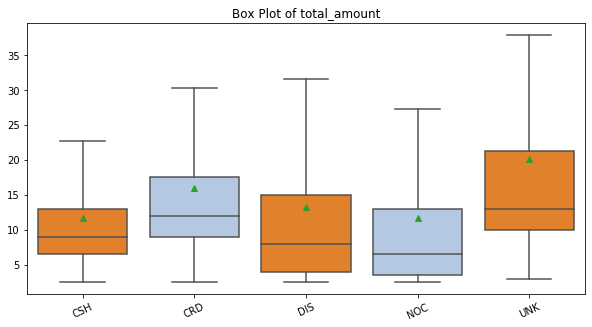

----------------------------------------------------------------------------------------------------


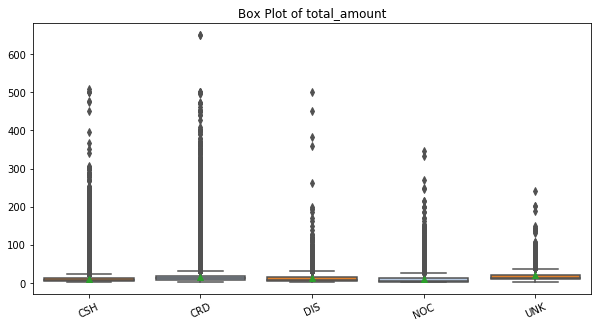

----------------------------------------------------------------------------------------------------


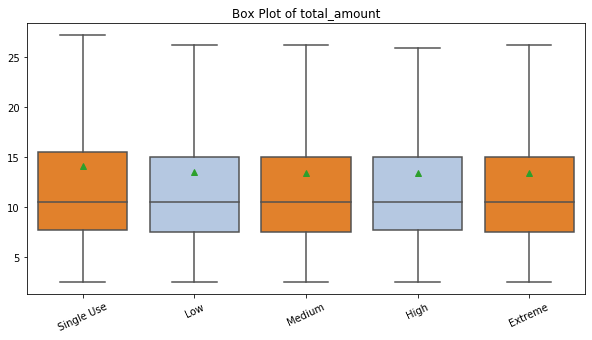

----------------------------------------------------------------------------------------------------


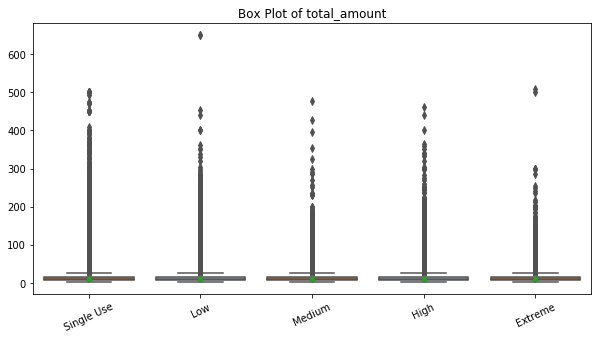

----------------------------------------------------------------------------------------------------


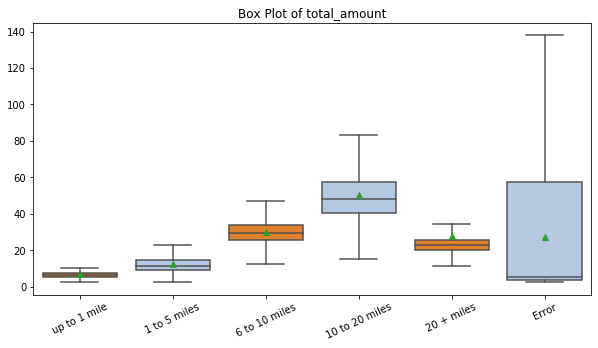

----------------------------------------------------------------------------------------------------


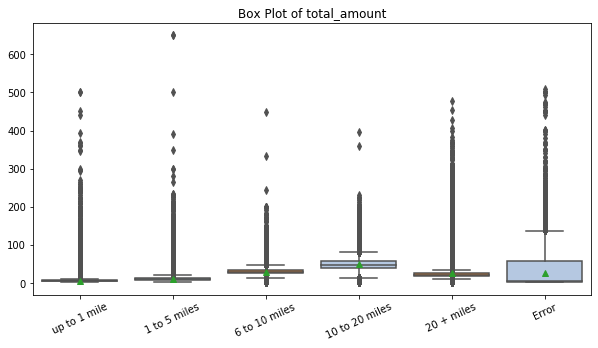

----------------------------------------------------------------------------------------------------


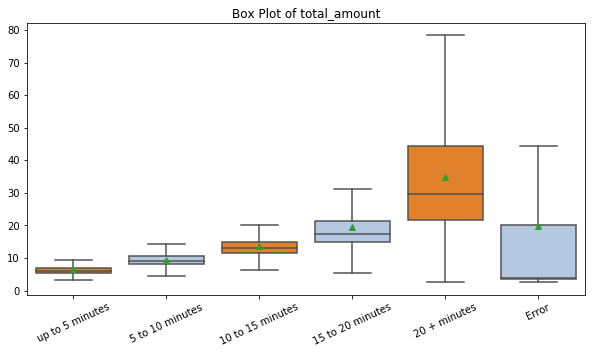

----------------------------------------------------------------------------------------------------


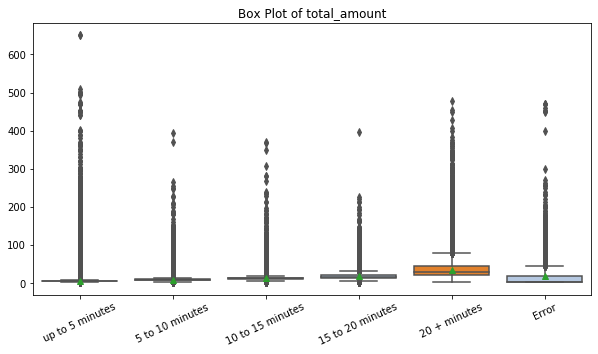

----------------------------------------------------------------------------------------------------


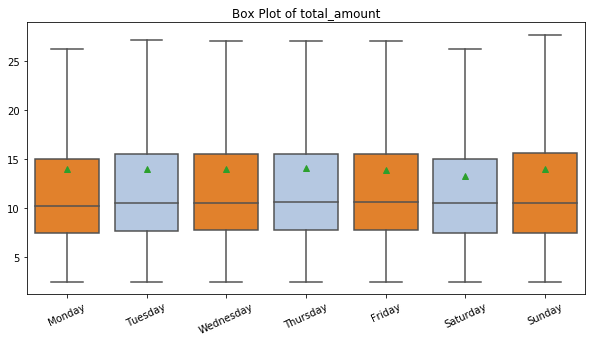

----------------------------------------------------------------------------------------------------


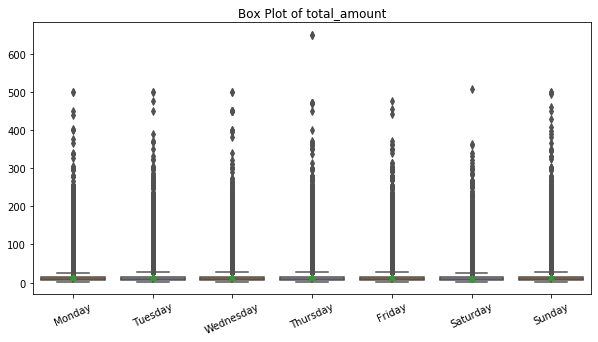

----------------------------------------------------------------------------------------------------


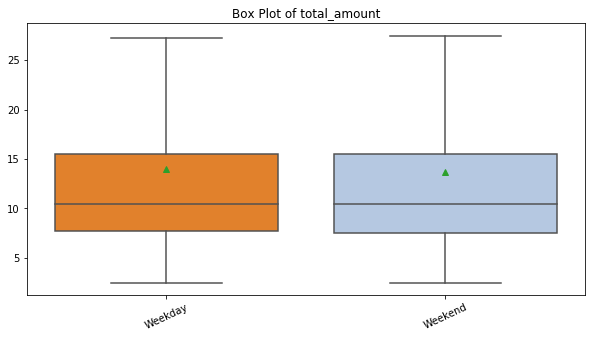

----------------------------------------------------------------------------------------------------


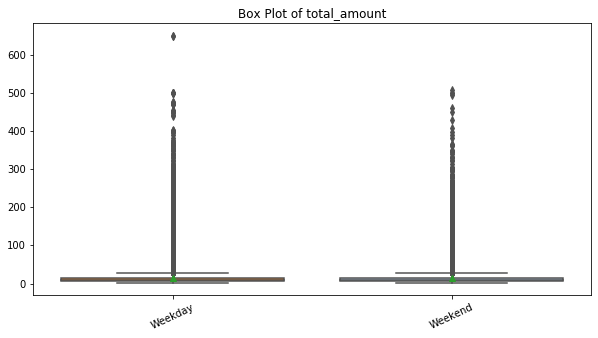

----------------------------------------------------------------------------------------------------


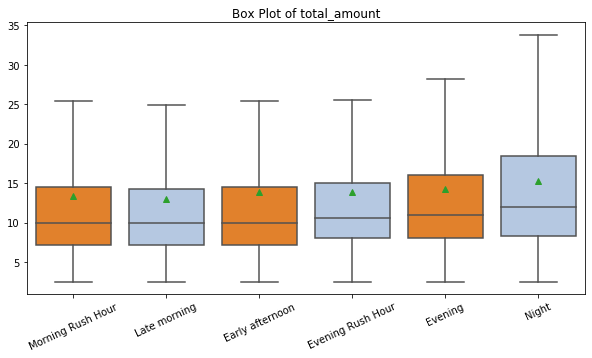

----------------------------------------------------------------------------------------------------


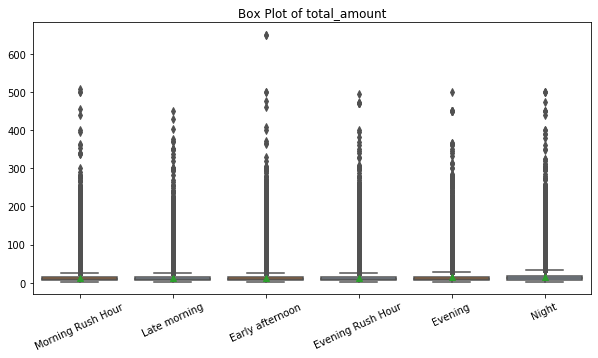

----------------------------------------------------------------------------------------------------


In [135]:
plotValue = ['total_amount']
byValue = ['vendor_id', 'payment_type', 'Taxi Use', 'tripLength', 'tripDuration',  'pickup_dayName', \
           'pickup_weekdayWeekend', 'pickup_timeOfDay']

for pv in plotValue:
    for bv in byValue:
        #reorder the df to print nicely
        key = tripDataFare[bv].map(retOrderMapping(bv))
        tripDataFare = tripDataFare.iloc[key.argsort()]
        #print the first chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=False)
        # print the second chart without outliers
        comparisonBoxplots(
            tripDataFare[bv],
            tripDataFare[pv],
            palette=[my_colors[2], my_colors[1]],
            title="Box Plot of " + pv,
            showmeans=True,
            showfliers=True)

In [137]:
#save data
#tripDataFare.to_pickle('tripDataFare_Final'+dt+'.pkl')

In [140]:
tripDataFare[['payment_type','pickup_dayName', 'medallion']].groupby(['payment_type','pickup_dayName']).count()

medallion
payment_type pickup_dayName           
CRD          Friday            1075273
             Monday             877570
             Saturday          1006018
             Sunday             892844
             Thursday          1320843
             Tuesday           1187995
             Wednesday         1234571
CSH          Friday             957731
             Monday             770476
             Saturday           997634
             Sunday             842551
             Thursday          1127835
             Tuesday           1083896
             Wednesday         1065032
DIS          Friday               1564
             Monday               1239
             Saturday             1557
             Sunday               1452
             Thursday             1689
             Tuesday              1757
             Wednesday            1671
NOC          Friday               4391
             Monday               3673
             Saturday             4393
             Sunday               4100
             Thursday             5354
             Tuesday              5046
             Wednesday            5113
UNK          Friday                683
             Monday                620
             Saturday              420
             Sunday                284
             Thursday             1022
             Tuesday               897
             Wednesday             969

In [ ]:
dir()
gc.collect()